In [1]:
import os
import numpy as np
import time
import csv
from tqdm import tqdm
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset, random_split
# from transformers import ConvNextForImageClassification нужен ли?
from torchvision.transforms.functional import to_pil_image
from torchvision import models,transforms

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from dataset import MNISTHAM10000
from utils import root, sorted_df_list, label_map, tensor_to_img, imgs_df, mod_imgs_df, multiply_factor, itm_list, get_sampler_weight, get_class_weights
from model import initialize_model
from train import train_model, model_test, device, model_test_Ef, train_model_Ef

## Dataset

In [2]:
# загружаем подготовленный df 
imgs_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx,full_cell_type_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,Benign keratosis-like lesions
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0,Actinic keratoses
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0,Actinic keratoses
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0,Actinic keratoses
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0,Actinic keratoses


In [8]:
multiply_factor(train_df, 'dx')

([6, 6, 13, 21, 44, 62], ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'])

In [3]:
# проверяем сбалансированность данных
imgs_df['full_cell_type_name'].value_counts()

full_cell_type_name
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

<Axes: xlabel='dx', ylabel='Count'>

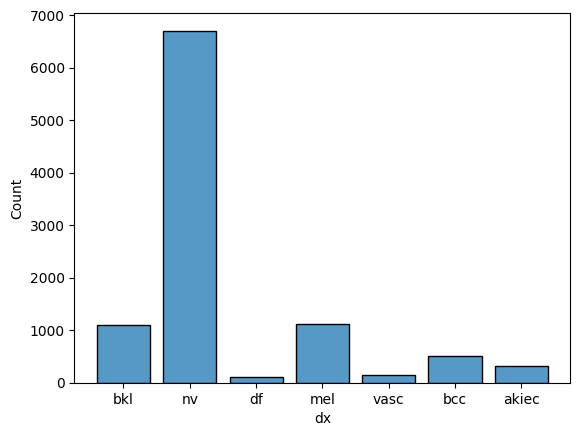

In [4]:
# проверяем сбалансированность данных
sns.histplot(data=imgs_df, x='dx', multiple="dodge", shrink=.8)

In [5]:
train_df, test_df = train_test_split(imgs_df, test_size=0.2, random_state=42) 
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [6]:
test_df['dx'].value_counts(), val_df['dx'].value_counts()

(dx
 nv       674
 bkl      113
 mel      113
 akiec     39
 bcc       38
 df        16
 vasc       8
 Name: count, dtype: int64,
 dx
 nv       664
 bkl      115
 mel      113
 bcc       55
 akiec     30
 vasc      13
 df        12
 Name: count, dtype: int64)

In [7]:
# задаем преобразования для данных для модели efficientformer (определенные требования к входному изображению)
img_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)), #300
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
            transforms.RandomRotation(degrees=(0, 180)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

test_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

mask_transform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
        ])

## Обучение CNN

### OVERSEMPLING

In [97]:
train_exm_dataset = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

#### tf_efficientnetv2

[epoch 1], [iter 200/1256], [train loss 0.979], [train acc 0.659]
[epoch 1], [iter 400/1256], [train loss 0.792], [train acc 0.722]
[epoch 1], [iter 600/1256], [train loss 0.699], [train acc 0.752]
[epoch 1], [iter 800/1256], [train loss 0.648], [train acc 0.767]
[epoch 1], [iter 1000/1256], [train loss 0.605], [train acc 0.781]
[epoch 1], [iter 1200/1256], [train loss 0.567], [train acc 0.794]
------------------------------------------------------------
Validation [epoch 1], [loss 0.833], [acc 0.747]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/1256], [train loss 0.367], [train acc 0.863]
[epoch 2], [iter 400/1256], [train loss 0.360], [train acc 0.867]
[epoch 2], [iter 600/1256], [train loss 0.347], [train acc 0.871]
[epoch 2], [iter 800/1256], [train loss 0.336], [train acc 0.874]
[epoch 2], [iter 1000/1256], [train loss 0.327], [train acc 0.878]
[epoch 2], [iter 1200/1256], [train loss 0.319]

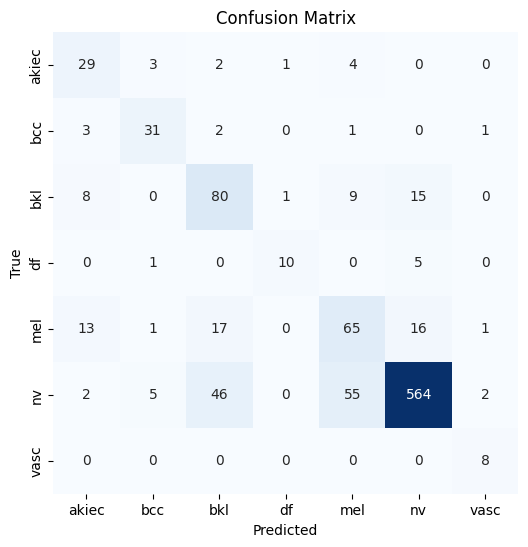

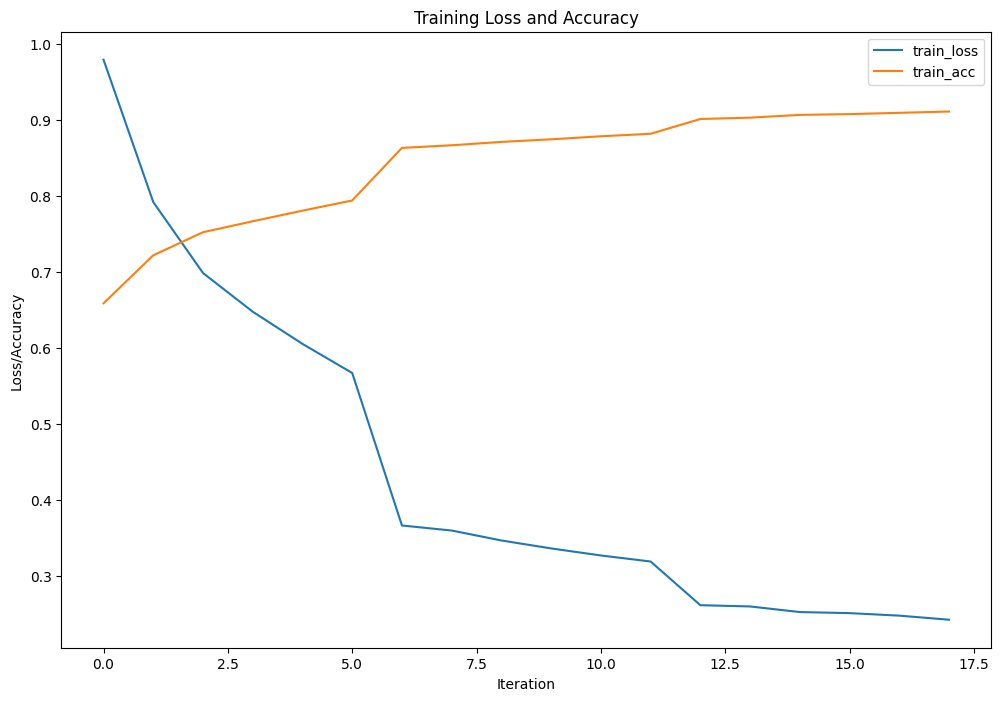

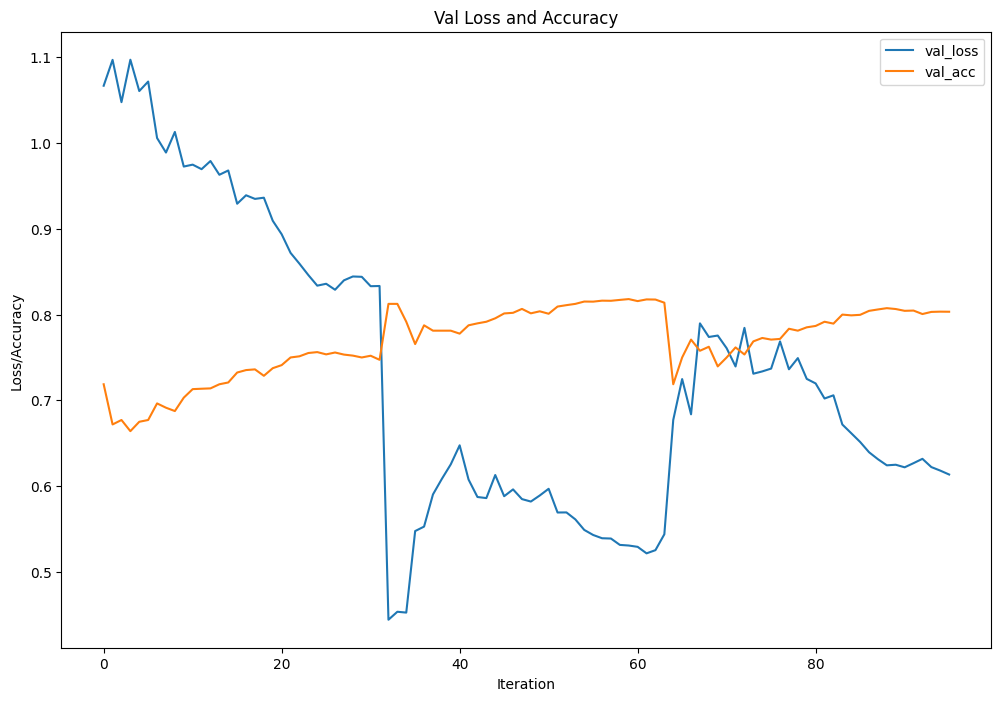

In [98]:
# file = open("Efv2_training_logs.csv", mode="w", newline="")
# writer = csv.writer(file)
# writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

train_exm_dataset = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

#-----------------------------------------------------------------------------#

model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7) #tf_efficientnetv2_s

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 3
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # Define the file path where you want to save the model
# save_path = "model_model_Efv2.pth"
# # Save the trained model
# torch.save(model_Efv2, save_path)

In [9]:
train_exm_dataset = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 6), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

<Axes: xlabel='dx', ylabel='Count'>

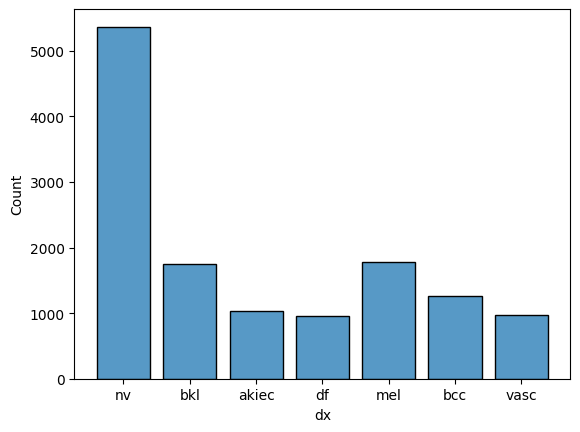

In [10]:
sns.histplot(data=train_exm_dataset.augmented_df, x='dx', multiple="dodge", shrink=.8)

[epoch 1], [iter 200/410], [train loss 1.003], [train acc 0.652]
[epoch 1], [iter 400/410], [train loss 0.848], [train acc 0.698]
------------------------------------------------------------
Validation [epoch 1], [loss 0.667], [acc 0.754]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/410], [train loss 0.577], [train acc 0.776]
[epoch 2], [iter 400/410], [train loss 0.556], [train acc 0.789]
------------------------------------------------------------
Validation [epoch 2], [loss 0.549], [acc 0.783]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/410], [train loss 0.485], [train acc 0.819]
[epoch 3], [iter 400/410], [train loss 0.472], [train acc 0.821]
------------------------------------------------------------
Validation [epoch 3], [loss 0.534], [acc 0.837]
-----------------------------------------------------

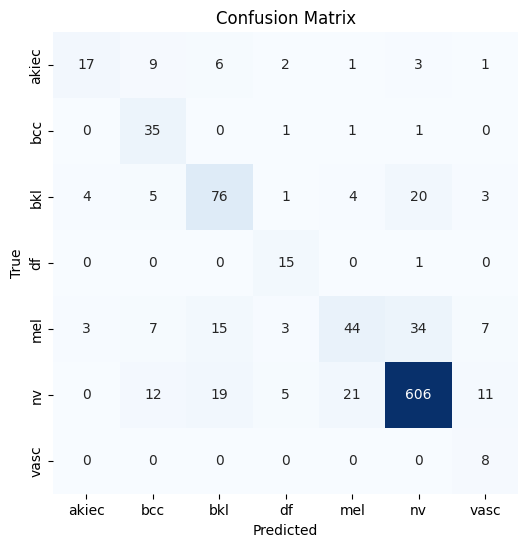

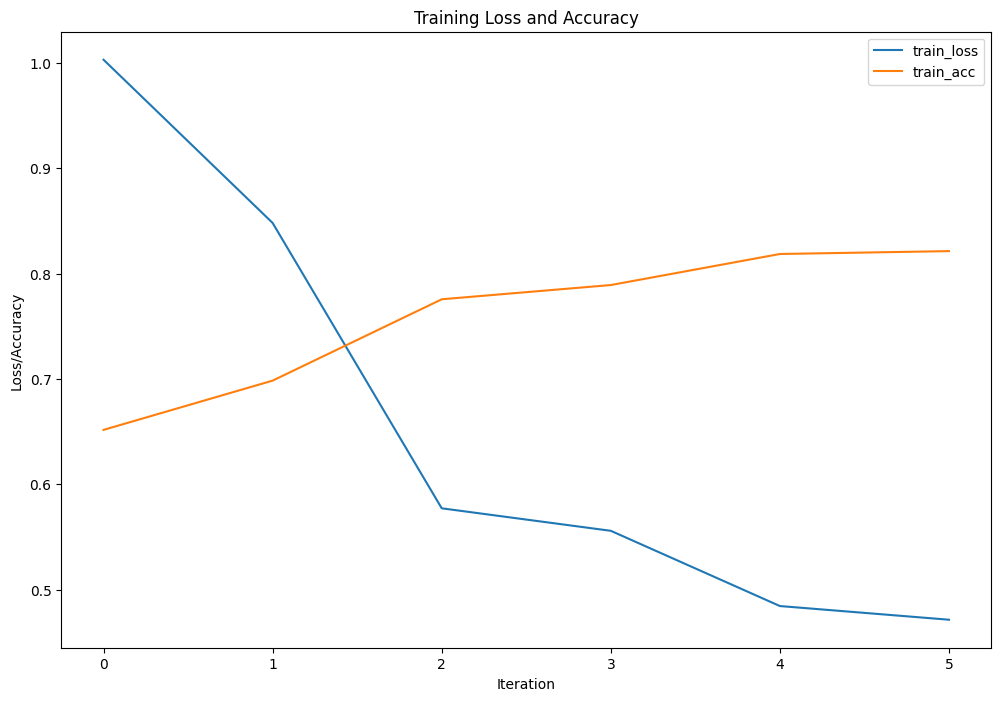

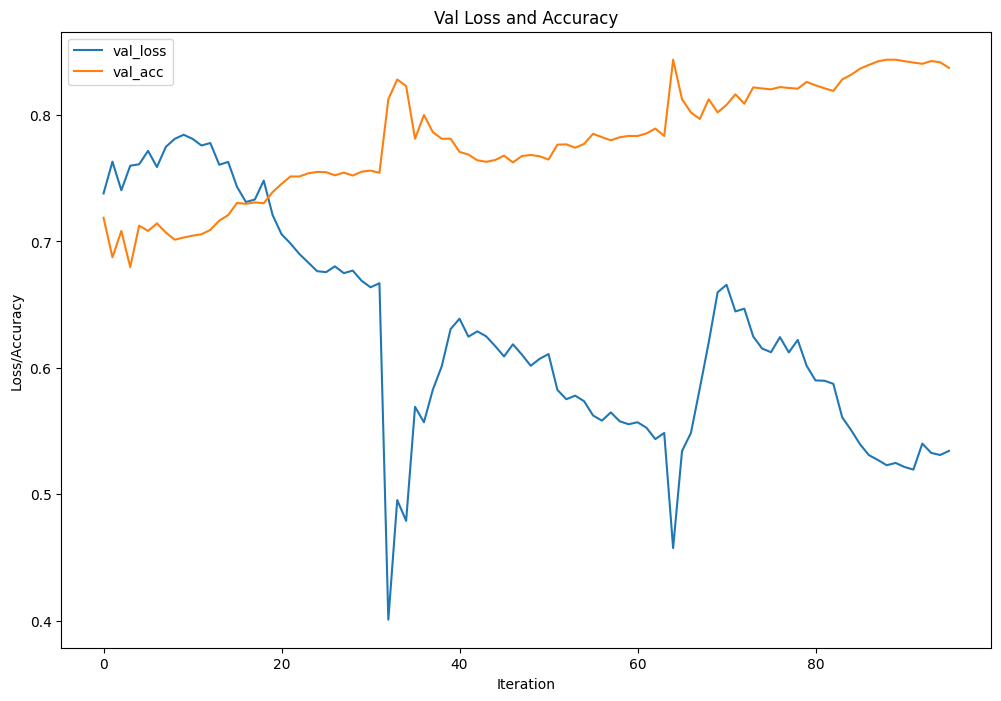

In [11]:
# file = open("Efv2_training_logs.csv", mode="w", newline="")
# writer = csv.writer(file)
# writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

#-----------------------------------------------------------------------------#

model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7) #tf_efficientnetv2_s

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 3
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # Define the file path where you want to save the model
# save_path = "model_model_Efv2.pth"
# # Save the trained model
# torch.save(model_Efv2, save_path)

In [12]:
train_exm_dataset = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 2), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

<Axes: xlabel='dx', ylabel='Count'>

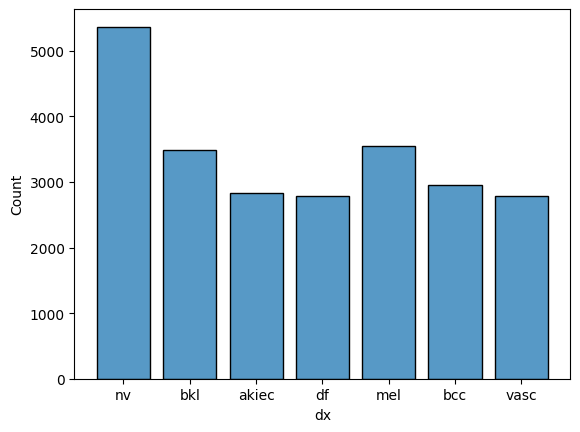

In [13]:
sns.histplot(data=train_exm_dataset.augmented_df, x='dx', multiple="dodge", shrink=.8)

[epoch 1], [iter 200/743], [train loss 1.024], [train acc 0.632]
[epoch 1], [iter 400/743], [train loss 0.836], [train acc 0.695]
[epoch 1], [iter 600/743], [train loss 0.751], [train acc 0.725]
------------------------------------------------------------
Validation [epoch 1], [loss 0.622], [acc 0.763]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/743], [train loss 0.486], [train acc 0.822]
[epoch 2], [iter 400/743], [train loss 0.461], [train acc 0.828]
[epoch 2], [iter 600/743], [train loss 0.442], [train acc 0.834]
------------------------------------------------------------
Validation [epoch 2], [loss 0.505], [acc 0.822]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/743], [train loss 0.340], [train acc 0.868]
[epoch 3], [iter 400/743], [train loss 0.343], [train acc 0.869]
[epoch 3], [iter 600/743], [trai

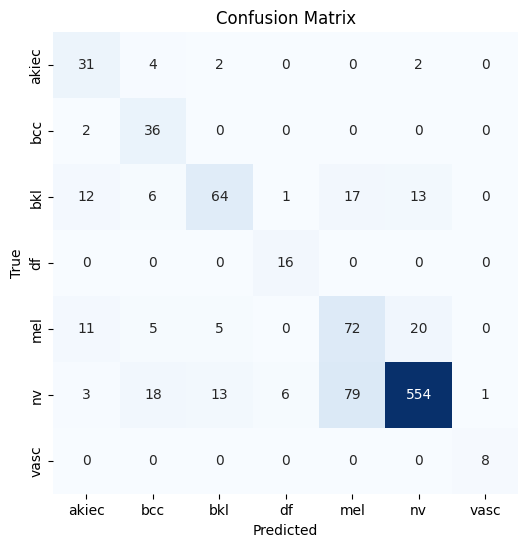

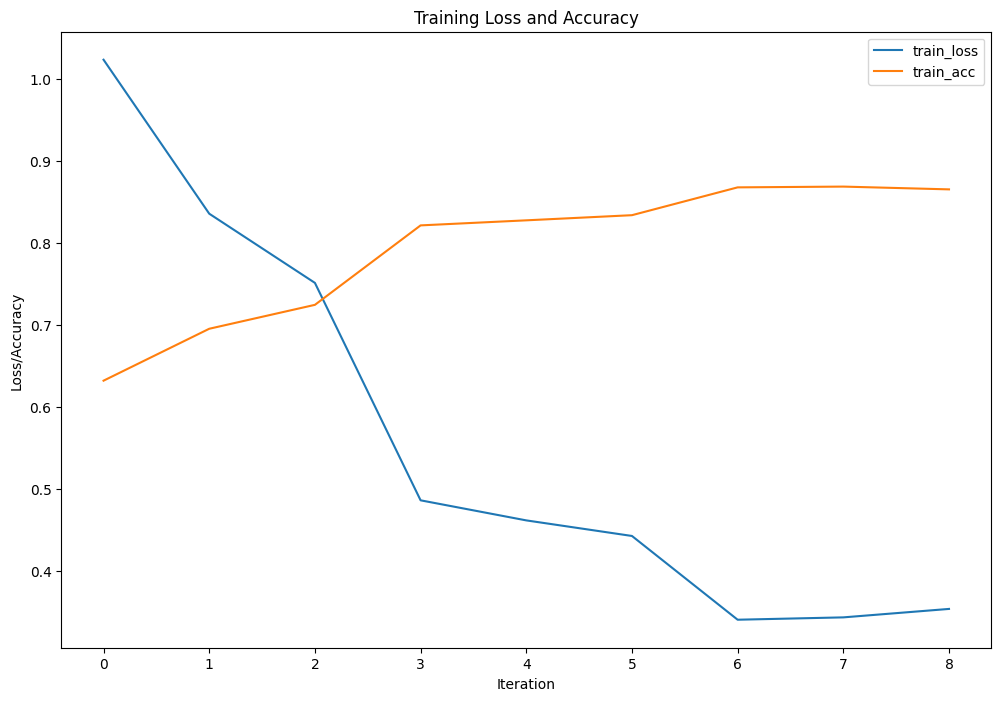

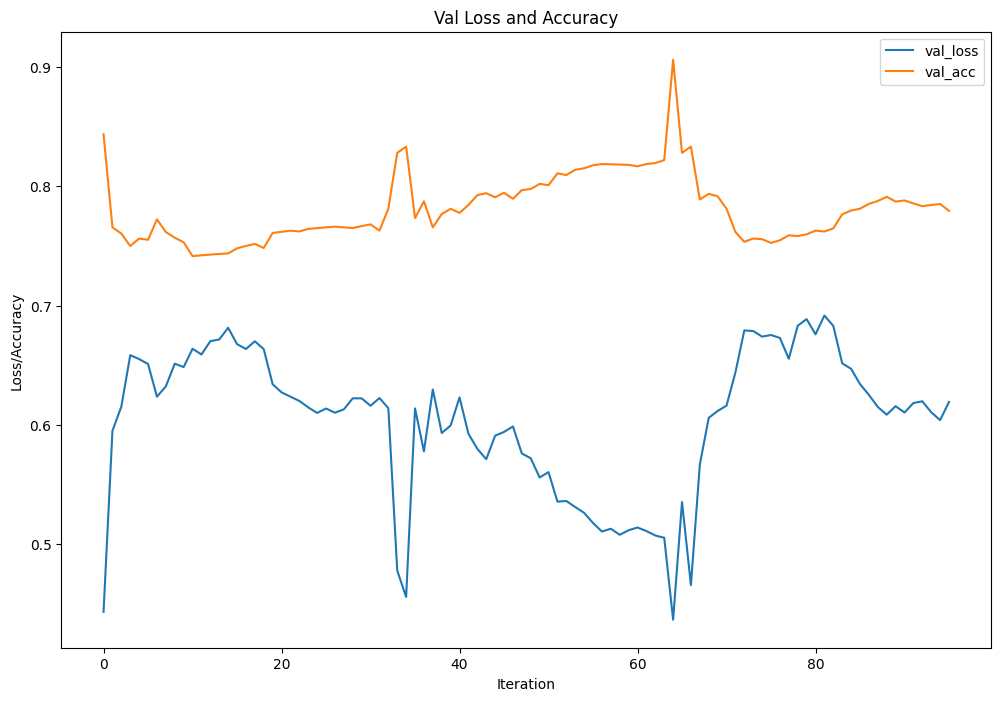

In [14]:
# file = open("Efv2_training_logs.csv", mode="w", newline="")
# writer = csv.writer(file)
# writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

#-----------------------------------------------------------------------------#

model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7) #tf_efficientnetv2_s

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 3
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # Define the file path where you want to save the model
# save_path = "model_model_Efv2.pth"
# # Save the trained model
# torch.save(model_Efv2, save_path)

#### MobileViTv2

[epoch 1], [iter 200/1256], [train loss 0.950], [train acc 0.665]
[epoch 1], [iter 400/1256], [train loss 0.777], [train acc 0.722]
[epoch 1], [iter 600/1256], [train loss 0.676], [train acc 0.758]
[epoch 1], [iter 800/1256], [train loss 0.612], [train acc 0.780]
[epoch 1], [iter 1000/1256], [train loss 0.567], [train acc 0.795]
[epoch 1], [iter 1200/1256], [train loss 0.530], [train acc 0.808]
------------------------------------------------------------
Validation [epoch 1], [loss 0.639], [acc 0.748]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/1256], [train loss 0.305], [train acc 0.889]
[epoch 2], [iter 400/1256], [train loss 0.286], [train acc 0.897]
[epoch 2], [iter 600/1256], [train loss 0.281], [train acc 0.899]
[epoch 2], [iter 800/1256], [train loss 0.272], [train acc 0.901]
[epoch 2], [iter 1000/1256], [train loss 0.266], [train acc 0.903]
[epoch 2], [iter 1200/1256], [train loss 0.257]

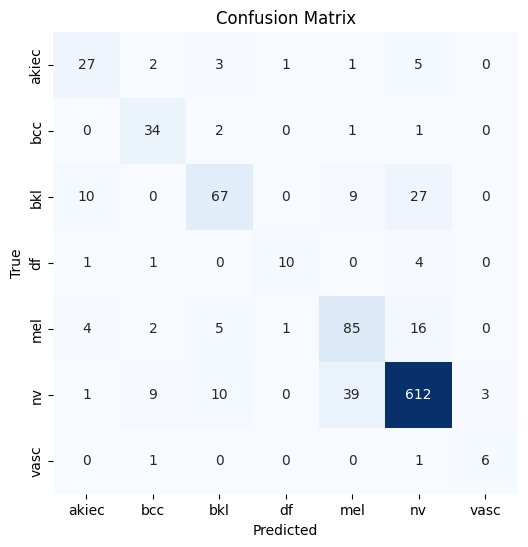

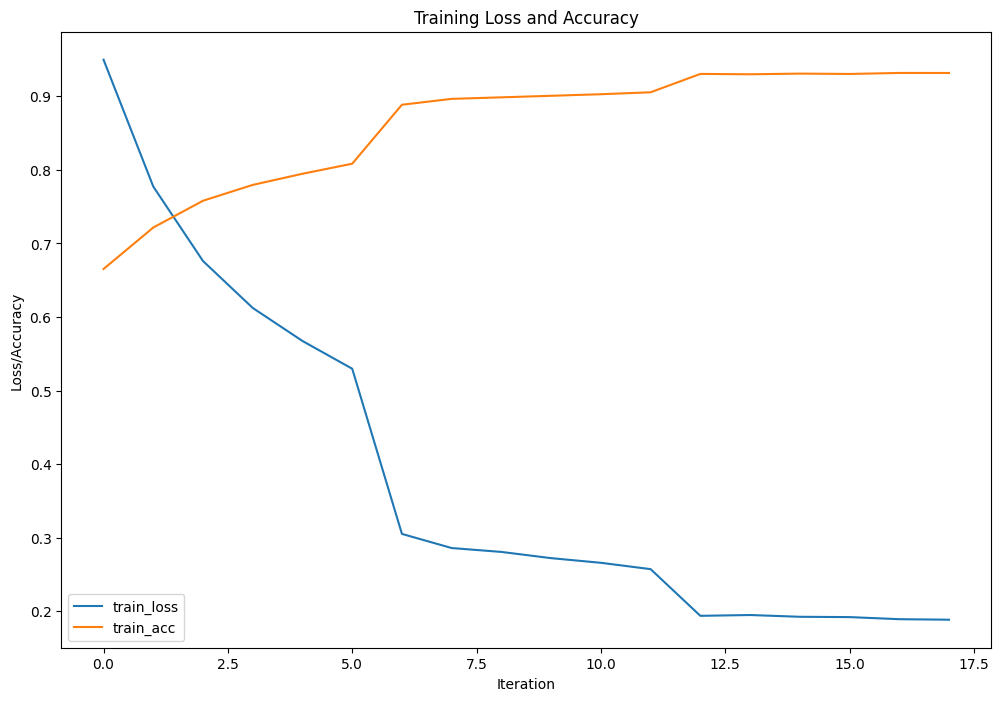

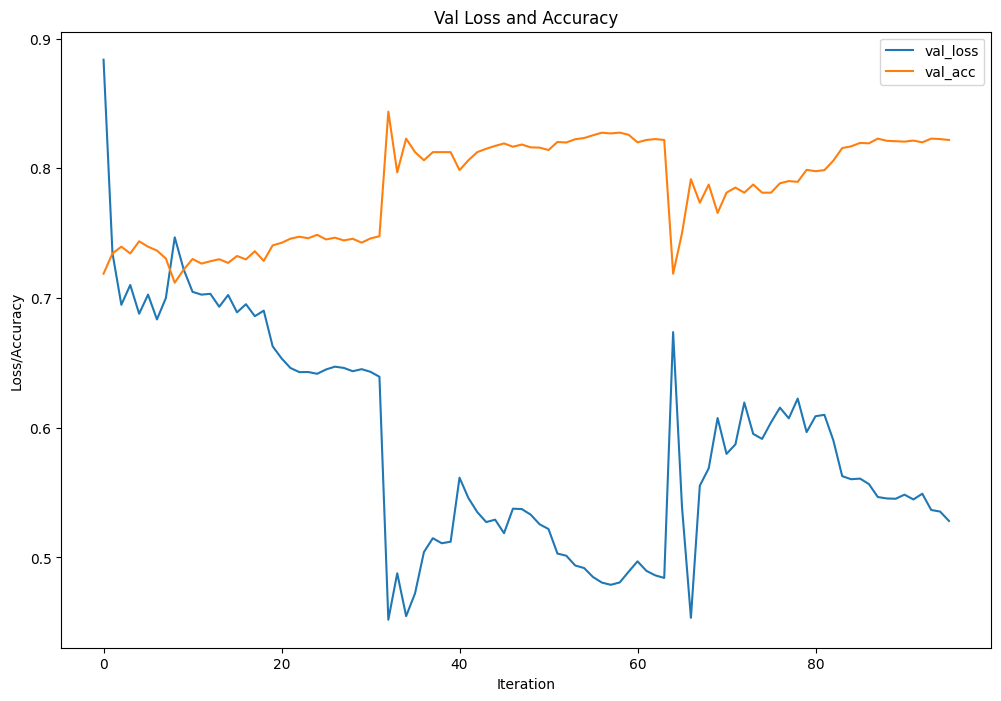

In [21]:
# file = open("mobilevitv2_training_logs.csv", mode="w", newline="")
# writer = csv.writer(file)
# writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 3
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "model_mobilevitv2.pth"
# # Save the trained model
# torch.save(model_mobilevitv2, save_path)

[epoch 1], [iter 200/444], [train loss 0.956], [train acc 0.661]
[epoch 1], [iter 400/444], [train loss 0.790], [train acc 0.717]
------------------------------------------------------------
Validation [epoch 1], [loss 0.443], [acc 0.832]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/444], [train loss 0.507], [train acc 0.814]
[epoch 2], [iter 400/444], [train loss 0.486], [train acc 0.822]
------------------------------------------------------------
Validation [epoch 2], [loss 0.452], [acc 0.830]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/444], [train loss 0.403], [train acc 0.850]
[epoch 3], [iter 400/444], [train loss 0.391], [train acc 0.855]
------------------------------------------------------------
Validation [epoch 3], [loss 0.443], [acc 0.843]
-----------------------------------------------------

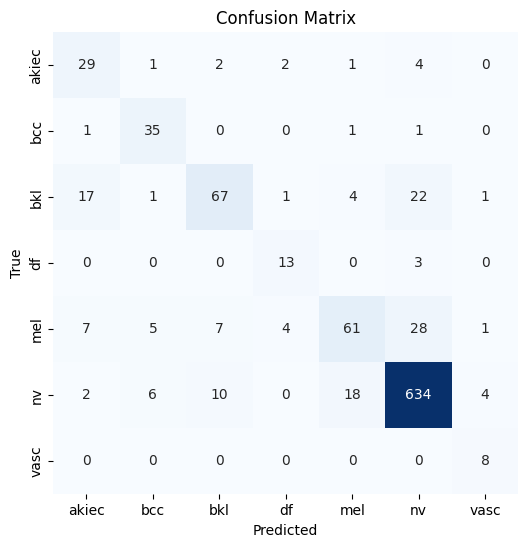

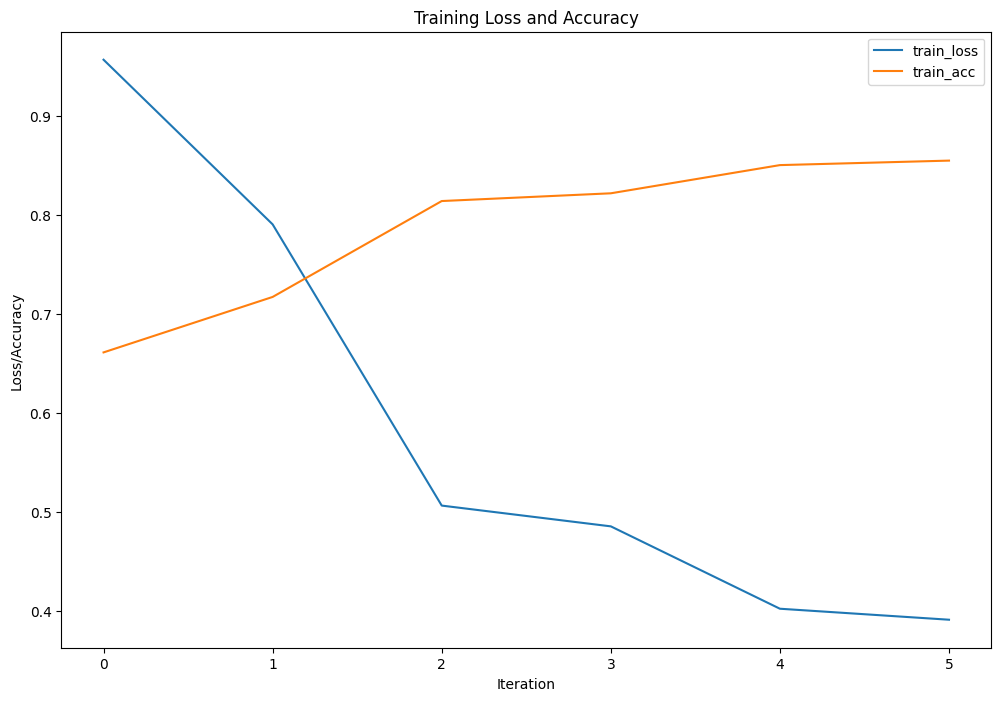

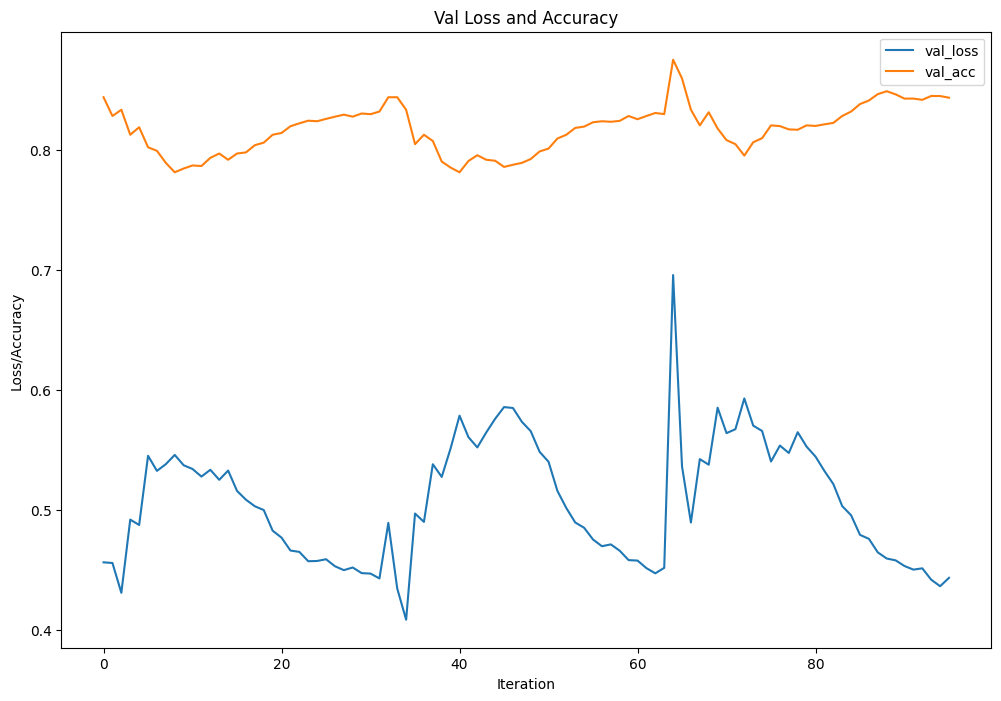

In [15]:
# file = open("mobilevitv2_training_logs.csv", mode="w", newline="")
# writer = csv.writer(file)
# writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

train_exm_dataset = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 5), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

#-----------------------------------------------------------------------------#

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 3
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "model_mobilevitv2.pth"
# # Save the trained model
# torch.save(model_mobilevitv2, save_path)

[epoch 1], [iter 200/743], [train loss 0.972], [train acc 0.639]
[epoch 1], [iter 400/743], [train loss 0.796], [train acc 0.704]
[epoch 1], [iter 600/743], [train loss 0.705], [train acc 0.739]
------------------------------------------------------------
Validation [epoch 1], [loss 0.694], [acc 0.716]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/743], [train loss 0.414], [train acc 0.842]
[epoch 2], [iter 400/743], [train loss 0.397], [train acc 0.848]
[epoch 2], [iter 600/743], [train loss 0.374], [train acc 0.857]
------------------------------------------------------------
Validation [epoch 2], [loss 0.518], [acc 0.818]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/743], [train loss 0.292], [train acc 0.891]
[epoch 3], [iter 400/743], [train loss 0.293], [train acc 0.890]
[epoch 3], [iter 600/743], [trai

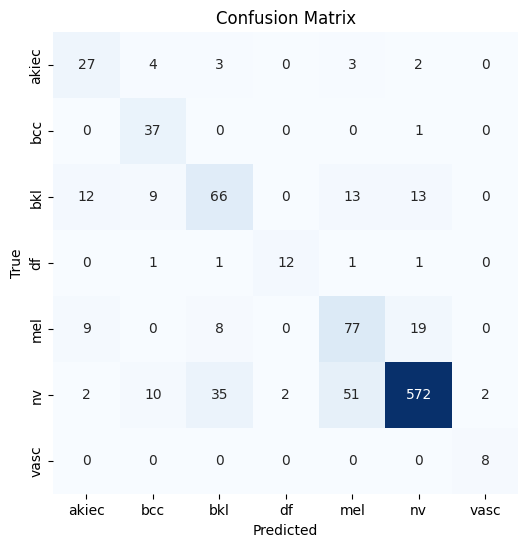

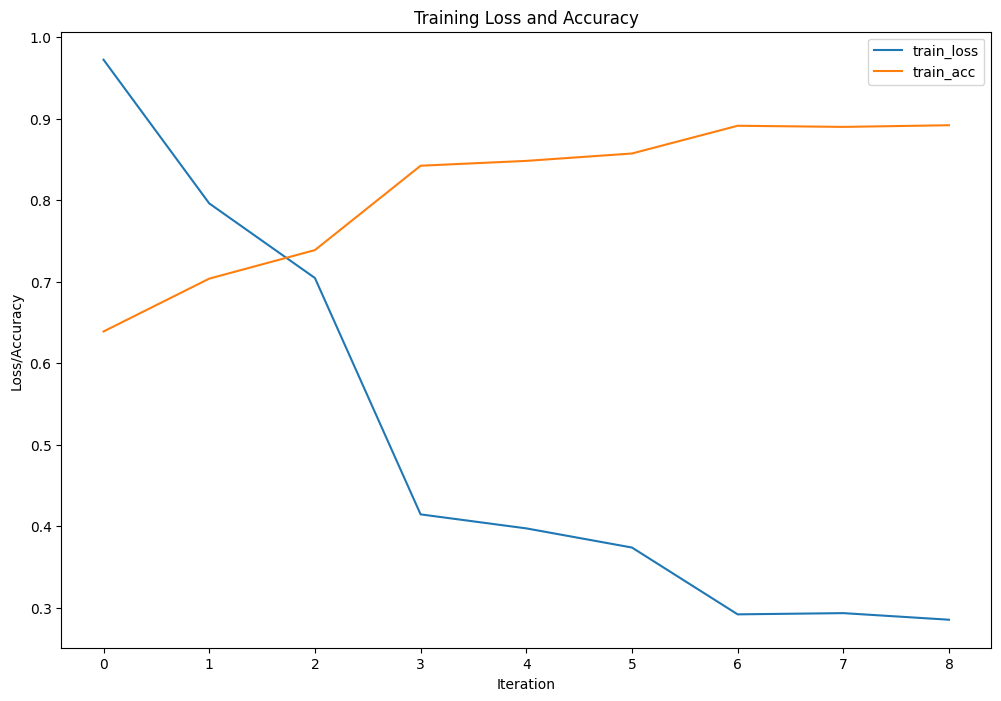

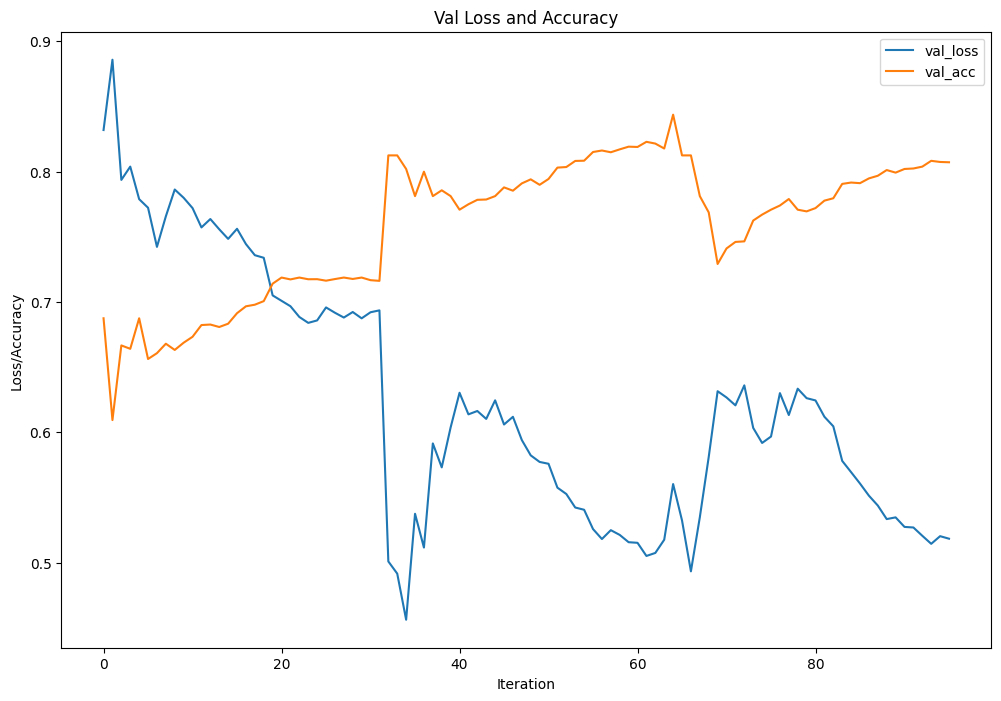

In [16]:
# file = open("mobilevitv2_training_logs.csv", mode="w", newline="")
# writer = csv.writer(file)
# writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

train_exm_dataset = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 2), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

#-----------------------------------------------------------------------------#

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 3
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "model_mobilevitv2.pth"
# # Save the trained model
# torch.save(model_mobilevitv2, save_path)

### class waights

In [56]:
train_exm_dataset = MNISTHAM10000(root, train_df, False, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, shuffle=True)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

In [57]:
class_counts = torch.tensor(train_exm_dataset.augmented_df['cell_type_idx'].values)
class_counts = torch.bincount(class_counts)
class_weights = 1. / class_counts
class_weights

tensor([0.0039, 0.0024, 0.0011, 0.0115, 0.0011, 0.0002, 0.0083])

#### tf_efficientnetv2

[epoch 1], [iter 50/251], [train loss 2.059], [train acc 0.369]
[epoch 1], [iter 100/251], [train loss 2.222], [train acc 0.373]
[epoch 1], [iter 150/251], [train loss 2.106], [train acc 0.386]
[epoch 1], [iter 200/251], [train loss 1.951], [train acc 0.416]
[epoch 1], [iter 250/251], [train loss 1.825], [train acc 0.443]
------------------------------------------------------------
Validation [epoch 1], [loss 1.180], [acc 0.558]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 50/251], [train loss 1.299], [train acc 0.512]
[epoch 2], [iter 100/251], [train loss 1.266], [train acc 0.547]
[epoch 2], [iter 150/251], [train loss 1.250], [train acc 0.554]
[epoch 2], [iter 200/251], [train loss 1.214], [train acc 0.548]
[epoch 2], [iter 250/251], [train loss 1.204], [train acc 0.559]
------------------------------------------------------------
Validation [epoch 2], [loss 2.405], [acc 0.589]
-------------------

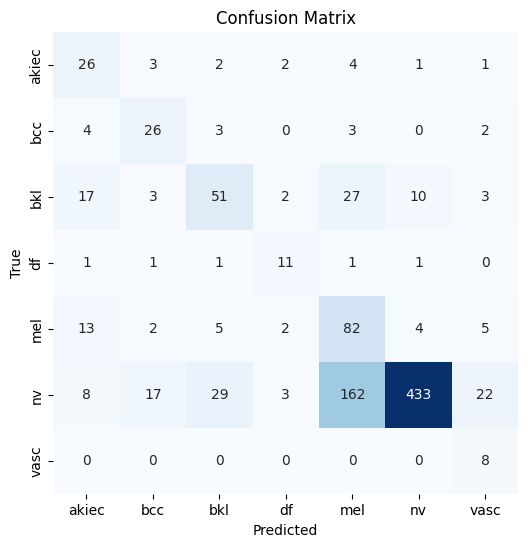

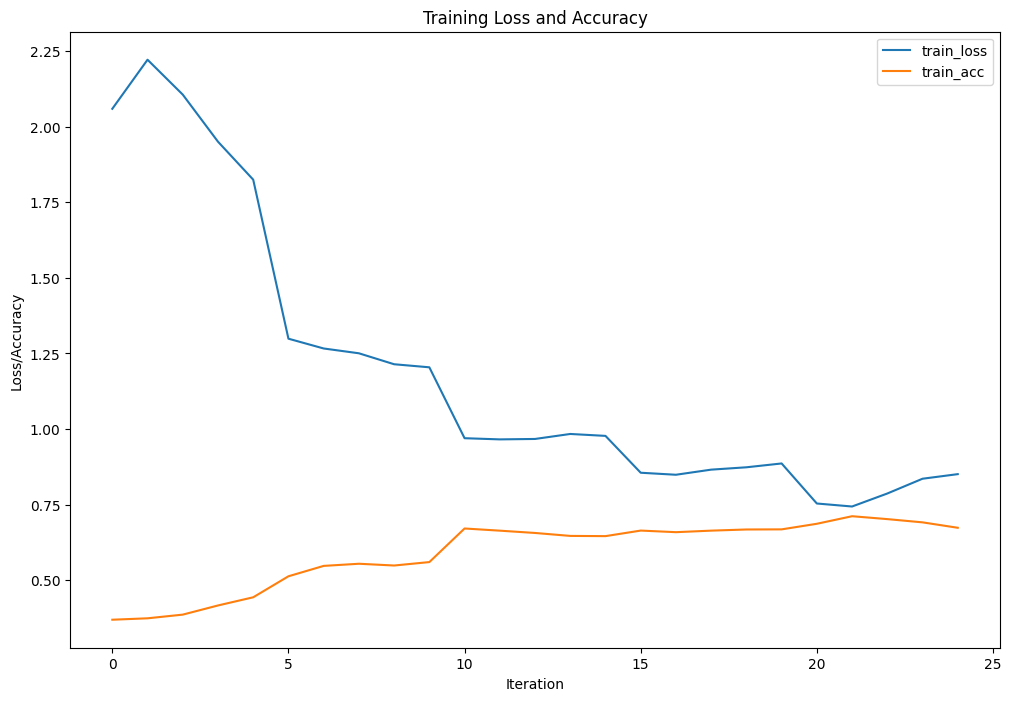

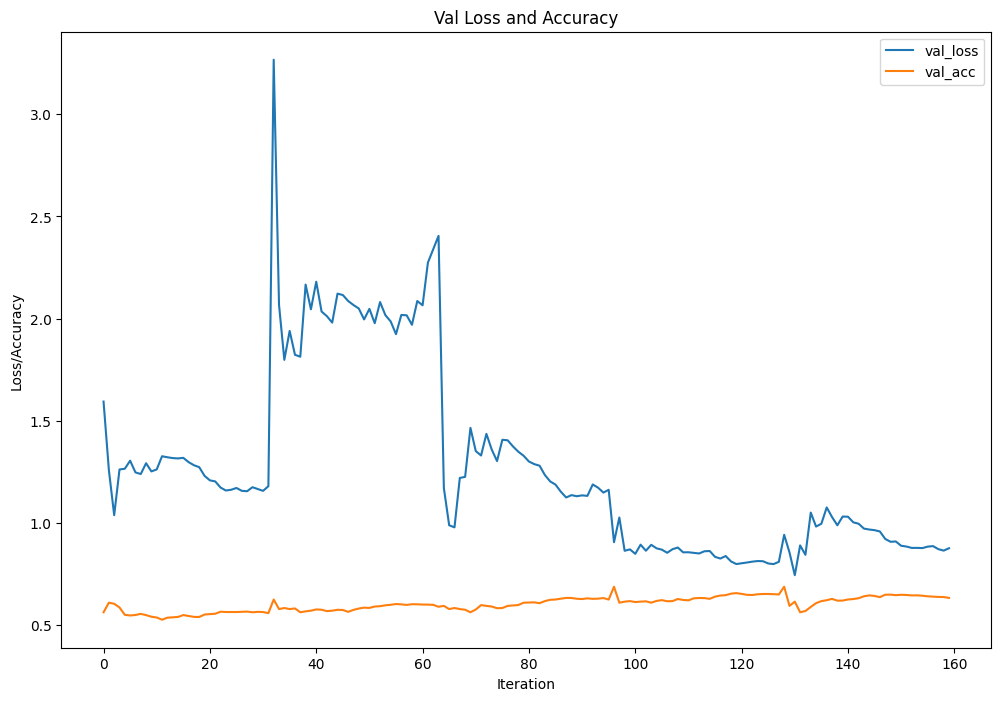

In [49]:

model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7) #tf_efficientnetv2_s

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_Efv2, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # Define the file path where you want to save the model
# save_path = "model_efficientformer.pth"
# # Save the trained model
# torch.save(EF_model, save_path)

#### MobileViTv2

[epoch 1], [iter 50/251], [train loss 1.634], [train acc 0.380]
[epoch 1], [iter 100/251], [train loss 1.500], [train acc 0.453]
[epoch 1], [iter 150/251], [train loss 1.373], [train acc 0.501]
[epoch 1], [iter 200/251], [train loss 1.308], [train acc 0.535]
[epoch 1], [iter 250/251], [train loss 1.269], [train acc 0.559]
------------------------------------------------------------
Validation [epoch 1], [loss 1.352], [acc 0.564]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 50/251], [train loss 1.041], [train acc 0.637]
[epoch 2], [iter 100/251], [train loss 0.981], [train acc 0.651]
[epoch 2], [iter 150/251], [train loss 0.982], [train acc 0.650]
[epoch 2], [iter 200/251], [train loss 0.985], [train acc 0.654]
[epoch 2], [iter 250/251], [train loss 1.003], [train acc 0.655]
------------------------------------------------------------
Validation [epoch 2], [loss 1.226], [acc 0.681]
-------------------

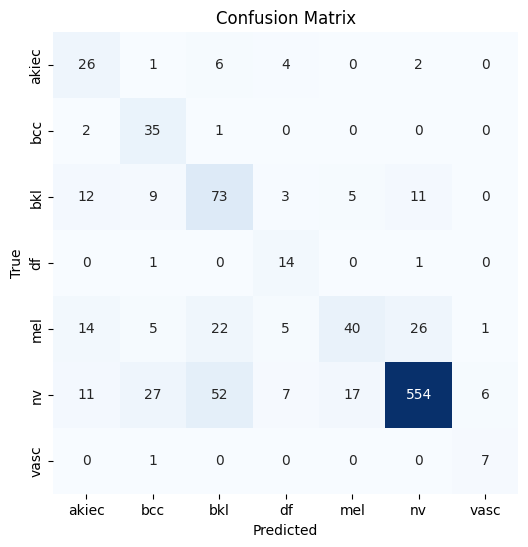

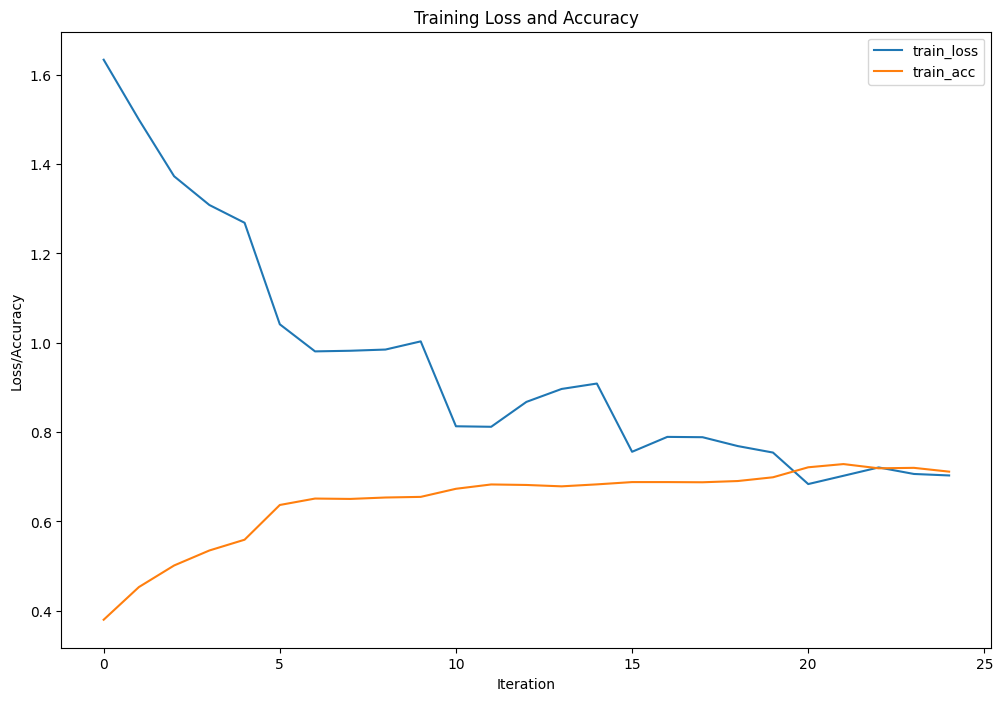

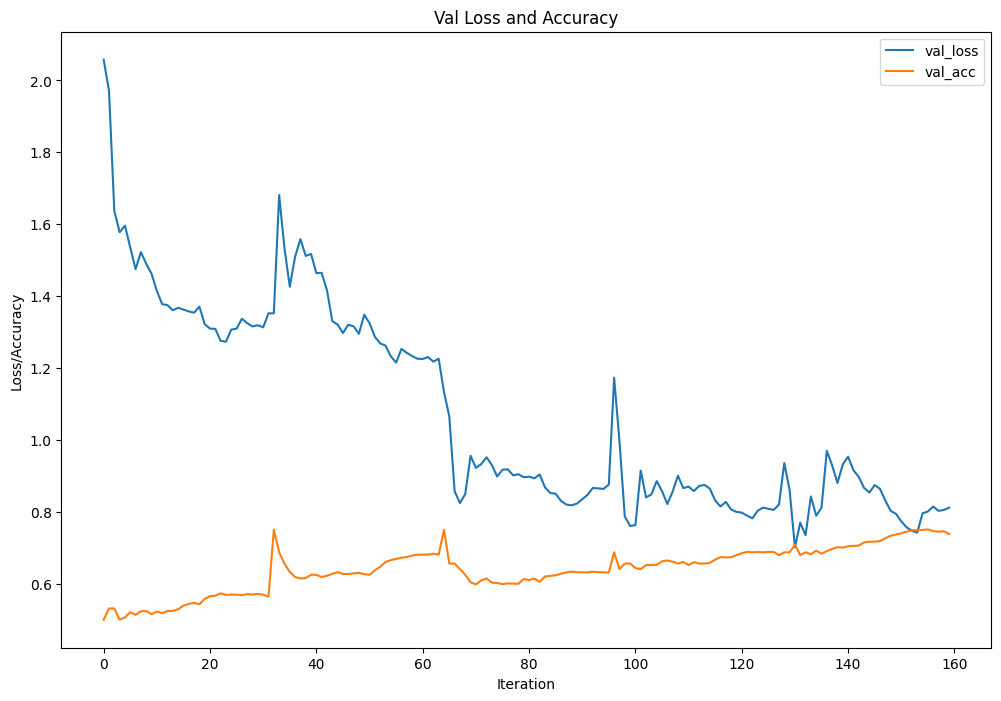

In [58]:
model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_mobilevitv2, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "model_resnet.pth"
# # Save the trained model
# # torch.save(model_resnet.state_dict(), save_path)
# torch.save(model_resnet, save_path)

### WeightedRandomSampler

In [59]:
def WRS_maker(df, columns):
    class_counts = torch.tensor(df[columns].value_counts())
    weights = 1. / class_counts.clone().detach().float()
    samples_weights = weights[df[columns].values]
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
    return sampler #, samples_weights

In [60]:
train_exm_dataset = MNISTHAM10000(root, train_df, False, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
full_sampler =  WRS_maker(train_df, 'cell_type_idx')
train_loader = DataLoader(
    train_exm_dataset, batch_size=32, sampler=full_sampler)

exm_dataset = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

exm_dataset = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=False)

#### tf_efficientnetv2

[epoch 1], [iter 50/251], [train loss 0.672], [train acc 0.824]
[epoch 1], [iter 100/251], [train loss 0.552], [train acc 0.849]
[epoch 1], [iter 150/251], [train loss 0.503], [train acc 0.858]
[epoch 1], [iter 200/251], [train loss 0.469], [train acc 0.864]
[epoch 1], [iter 250/251], [train loss 0.445], [train acc 0.868]
------------------------------------------------------------
Validation [epoch 1], [loss 1.038], [acc 0.710]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 50/251], [train loss 0.302], [train acc 0.901]
[epoch 2], [iter 100/251], [train loss 0.328], [train acc 0.892]
[epoch 2], [iter 150/251], [train loss 0.332], [train acc 0.891]
[epoch 2], [iter 200/251], [train loss 0.322], [train acc 0.896]
[epoch 2], [iter 250/251], [train loss 0.317], [train acc 0.897]
------------------------------------------------------------
Validation [epoch 2], [loss 0.984], [acc 0.713]
-------------------

C:\Users\Igor\anaconda3\envs\venv2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Igor\anaconda3\envs\venv2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Igor\anaconda3\envs\venv2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


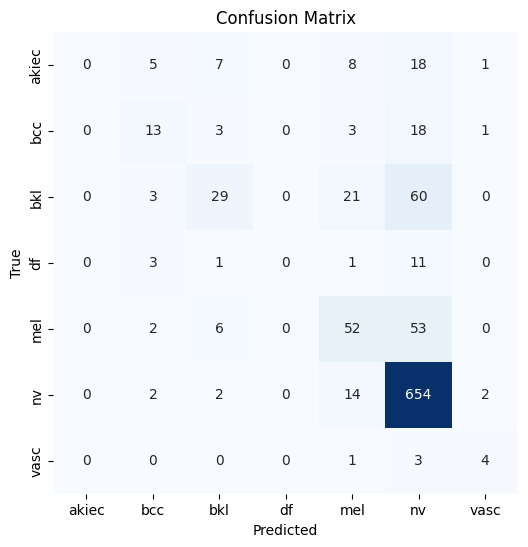

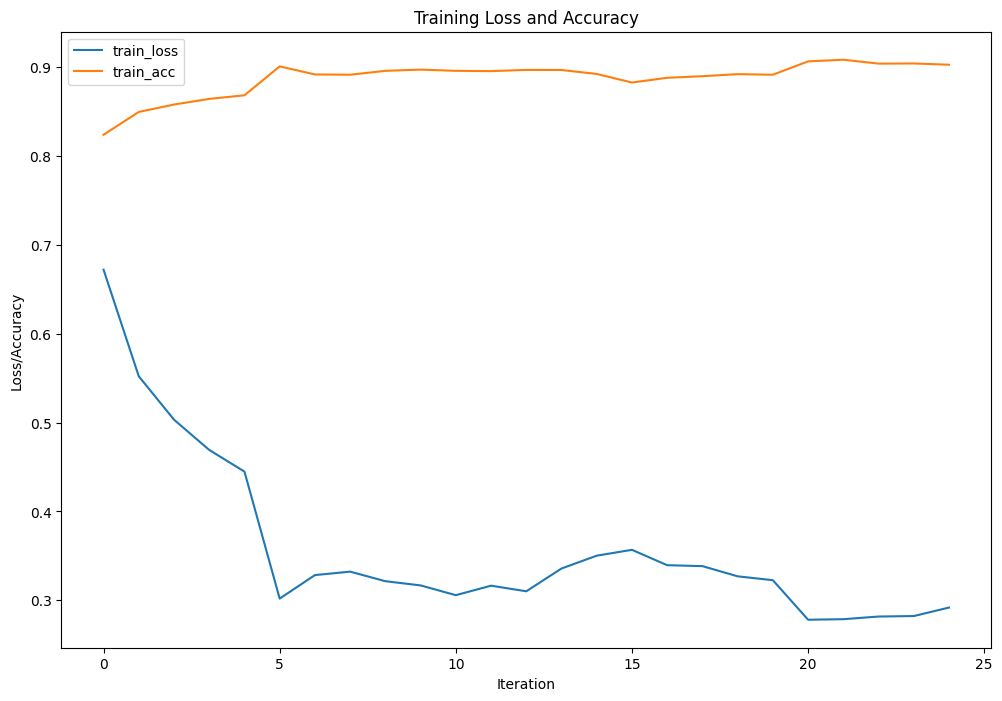

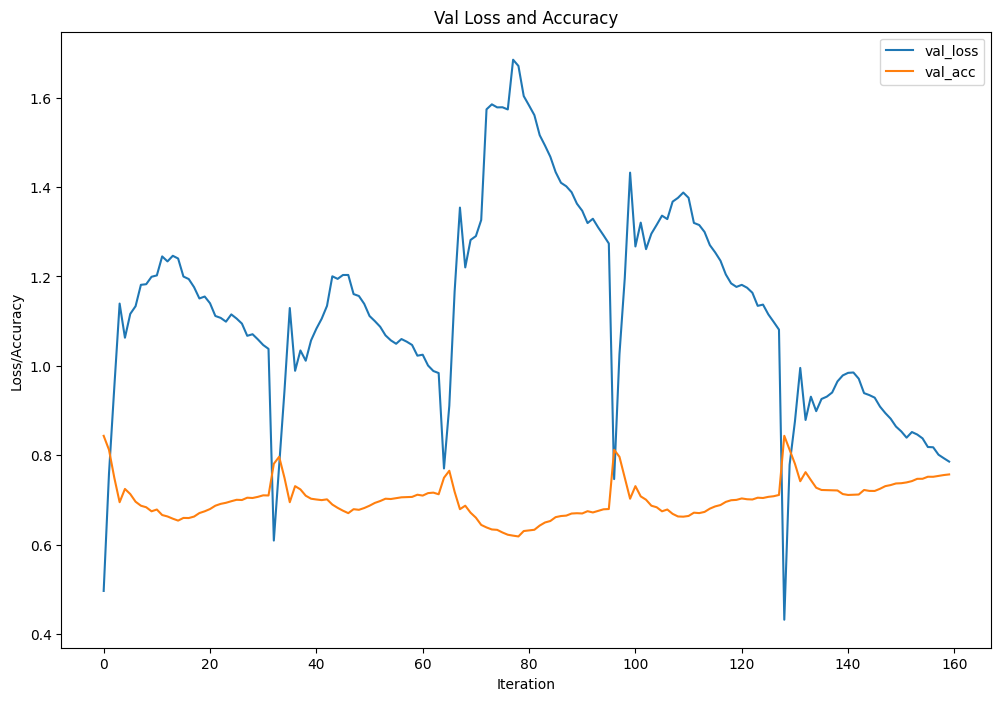

In [61]:
model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7)

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_Efv2, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_acc_test = model_test(test_loader, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### MobileViTv2

[epoch 1], [iter 50/251], [train loss 1.362], [train acc 0.726]
[epoch 1], [iter 100/251], [train loss 0.907], [train acc 0.803]
[epoch 1], [iter 150/251], [train loss 0.722], [train acc 0.836]
[epoch 1], [iter 200/251], [train loss 0.633], [train acc 0.849]
[epoch 1], [iter 250/251], [train loss 0.574], [train acc 0.858]
------------------------------------------------------------
Validation [epoch 1], [loss 0.965], [acc 0.690]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 50/251], [train loss 0.355], [train acc 0.887]
[epoch 2], [iter 100/251], [train loss 0.363], [train acc 0.887]
[epoch 2], [iter 150/251], [train loss 0.347], [train acc 0.890]
[epoch 2], [iter 200/251], [train loss 0.345], [train acc 0.891]
[epoch 2], [iter 250/251], [train loss 0.340], [train acc 0.893]
------------------------------------------------------------
Validation [epoch 2], [loss 0.773], [acc 0.729]
-------------------

C:\Users\Igor\anaconda3\envs\venv2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Igor\anaconda3\envs\venv2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Igor\anaconda3\envs\venv2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


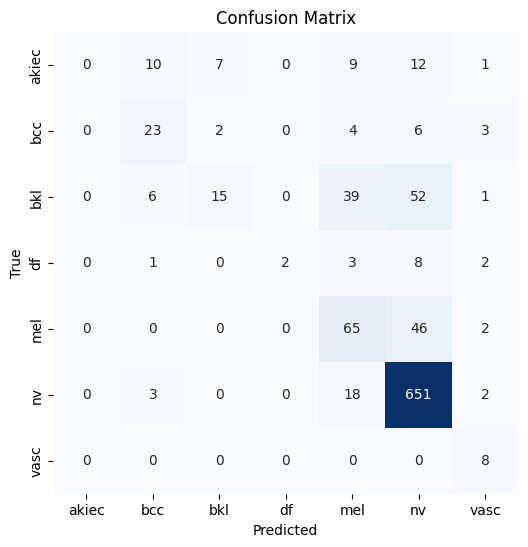

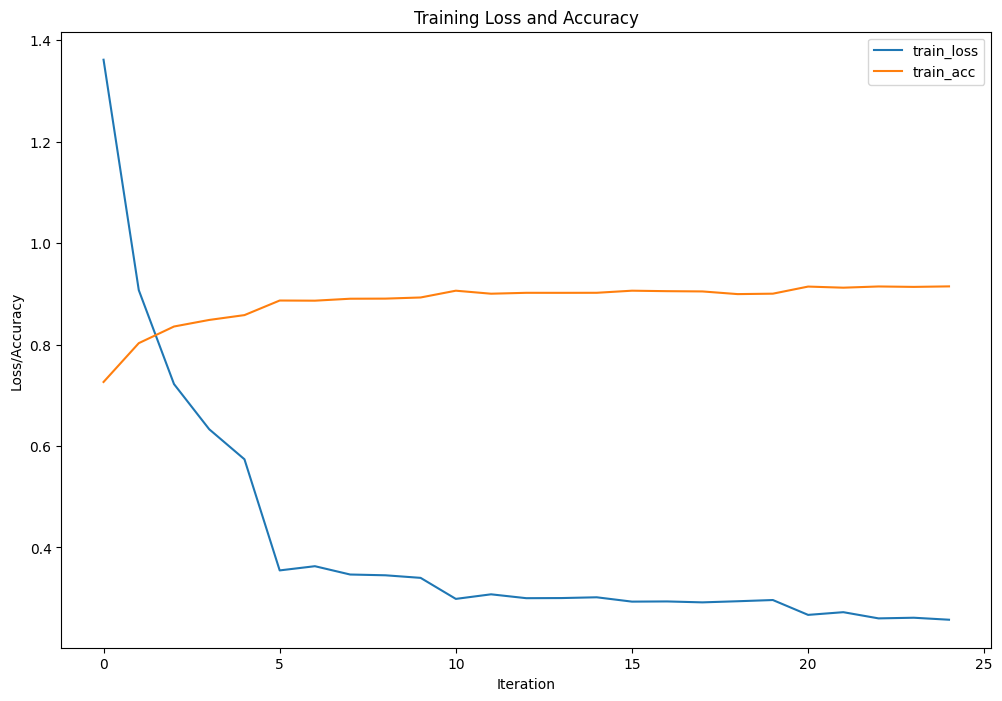

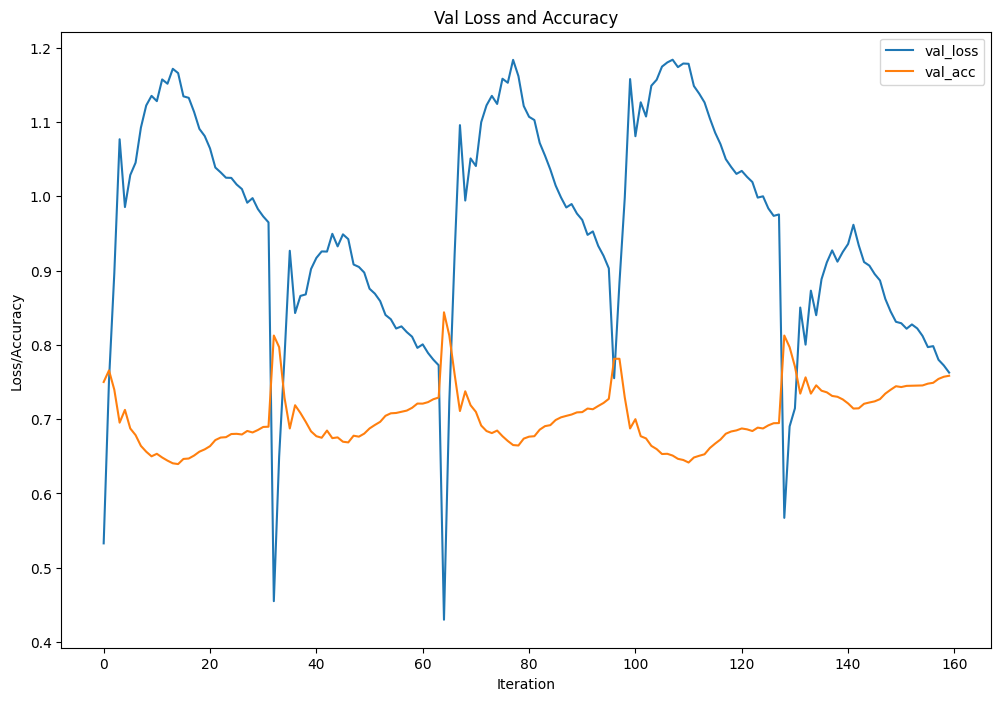

In [62]:
model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

#-----------------------------------------------------------------------------#

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss().to(device)

#-----------------------------------------------------------------------------#

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_mobilevitv2, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_acc_test = model_test(test_loader, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## PARSING

#### Data

In [10]:
mod_imgs_df

,image_id,diagnosis,from,dx,cell_type_idx
0,ISIC_0027419,benign keratosis-like lesions,original_ham10000,bkl,2
1,ISIC_0025030,benign keratosis-like lesions,original_ham10000,bkl,2
2,ISIC_0026769,benign keratosis-like lesions,original_ham10000,bkl,2
3,ISIC_0025661,benign keratosis-like lesions,original_ham10000,bkl,2
4,ISIC_0031633,benign keratosis-like lesions,original_ham10000,bkl,2
...,...,...,...,...,...
20484,ISIC_9936409,melanoma,DERM12345,mel,4
20485,ISIC_9958625,basal cell carcinoma,DERM12345,bcc,1
20486,ISIC_9964754,dermatofibroma,DERM12345,df,3
20487,ISIC_9967046,melanoma,DERM12345,mel,4


In [11]:
# проверяем сбалансированность данных
mod_imgs_df['dx'].value_counts()

dx
mel      6813
nv       6705
bcc      4884
bkl      1099
df        519
akiec     327
vasc      142
Name: count, dtype: int64

<Axes: xlabel='dx', ylabel='Count'>

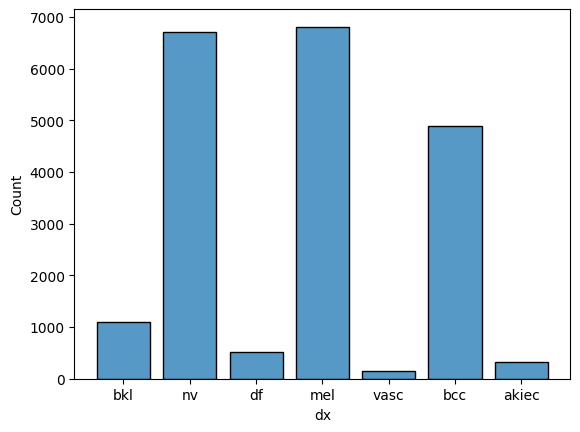

In [12]:
# проверяем сбалансированность данных
sns.histplot(data=mod_imgs_df, x='dx', multiple="dodge", shrink=.8)

In [13]:
train_df, test_df = train_test_split(mod_imgs_df, test_size=0.2, random_state=42) 
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [41]:
test_df.to_csv('test_df.csv', index=False)

In [14]:
# задаем преобразования для данных для модели efficientformer (определенные требования к входному изображению)
img_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)), #300
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
            transforms.RandomRotation(degrees=(0, 180)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

test_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

mask_transform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
        ])

In [36]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, False, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

#### tf_efficientnetv2

[epoch 1], [iter 50/513], [train loss 1.241], [train acc 0.611]
[epoch 1], [iter 100/513], [train loss 1.025], [train acc 0.656]
[epoch 1], [iter 150/513], [train loss 0.948], [train acc 0.674]
[epoch 1], [iter 200/513], [train loss 0.886], [train acc 0.691]
[epoch 1], [iter 250/513], [train loss 0.835], [train acc 0.705]
[epoch 1], [iter 300/513], [train loss 0.808], [train acc 0.712]
[epoch 1], [iter 350/513], [train loss 0.785], [train acc 0.719]
[epoch 1], [iter 400/513], [train loss 0.766], [train acc 0.725]
[epoch 1], [iter 450/513], [train loss 0.746], [train acc 0.731]
[epoch 1], [iter 500/513], [train loss 0.731], [train acc 0.736]
------------------------------------------------------------
Validation [epoch 1], [loss 0.524], [acc 0.813]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 50/513], [train loss 0.487], [train acc 0.818]
[epoch 2], [iter 100/513], [train loss 0.526], [train acc 0.812

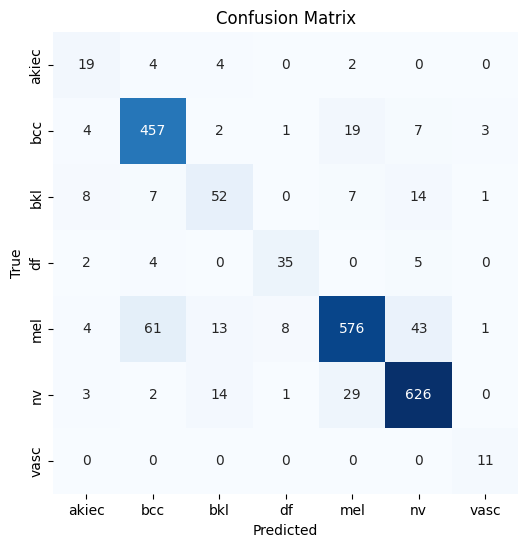

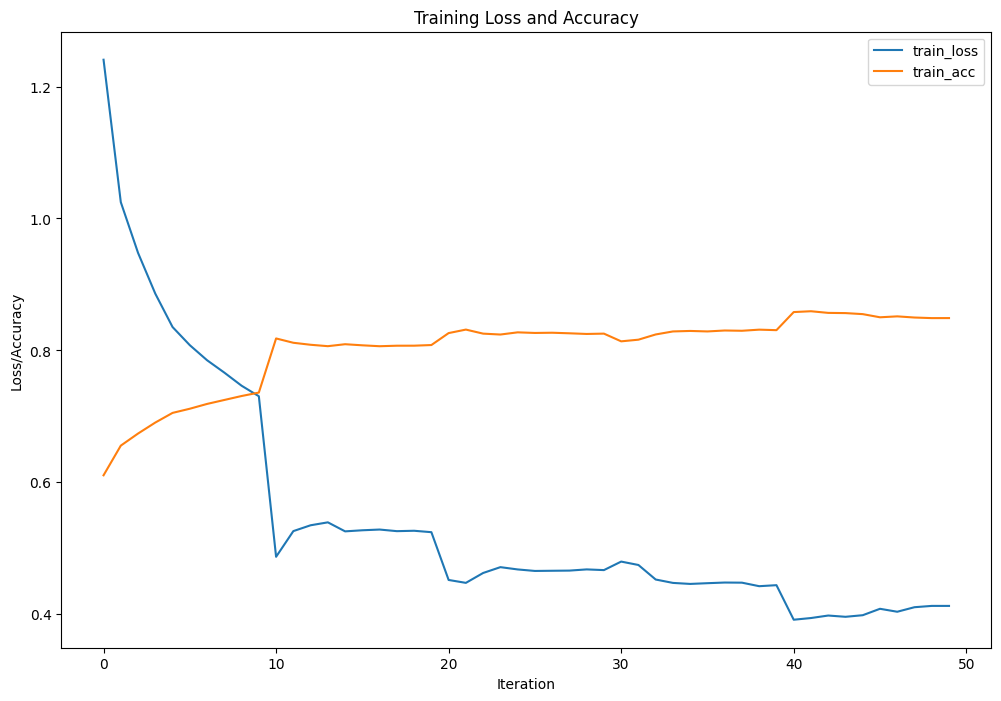

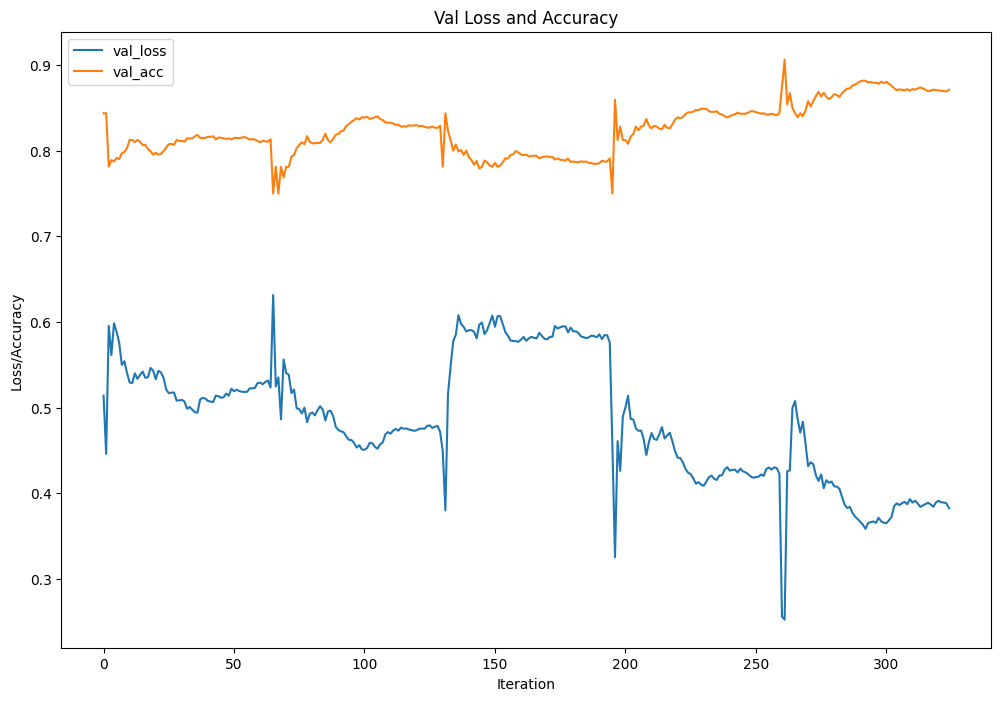

In [37]:
model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_Efv2, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### MobileViTv2

[epoch 1], [iter 50/513], [train loss 1.188], [train acc 0.644]
[epoch 1], [iter 100/513], [train loss 0.993], [train acc 0.682]
[epoch 1], [iter 150/513], [train loss 0.919], [train acc 0.693]
[epoch 1], [iter 200/513], [train loss 0.862], [train acc 0.706]
[epoch 1], [iter 250/513], [train loss 0.814], [train acc 0.719]
[epoch 1], [iter 300/513], [train loss 0.783], [train acc 0.728]
[epoch 1], [iter 350/513], [train loss 0.754], [train acc 0.738]
[epoch 1], [iter 400/513], [train loss 0.731], [train acc 0.744]
[epoch 1], [iter 450/513], [train loss 0.716], [train acc 0.747]
[epoch 1], [iter 500/513], [train loss 0.697], [train acc 0.753]
------------------------------------------------------------
Validation [epoch 1], [loss 0.507], [acc 0.810]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 50/513], [train loss 0.509], [train acc 0.814]
[epoch 2], [iter 100/513], [train loss 0.519], [train acc 0.810

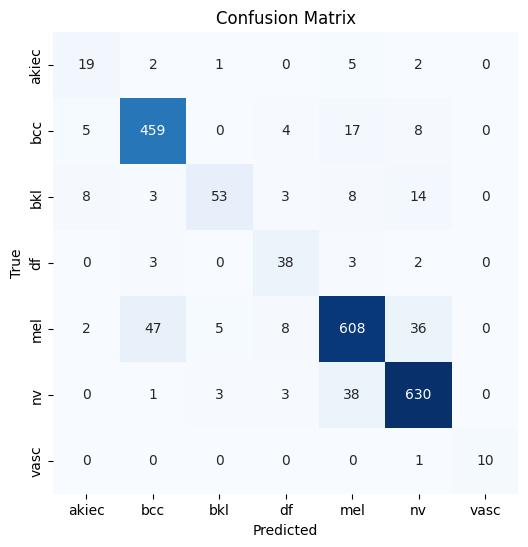

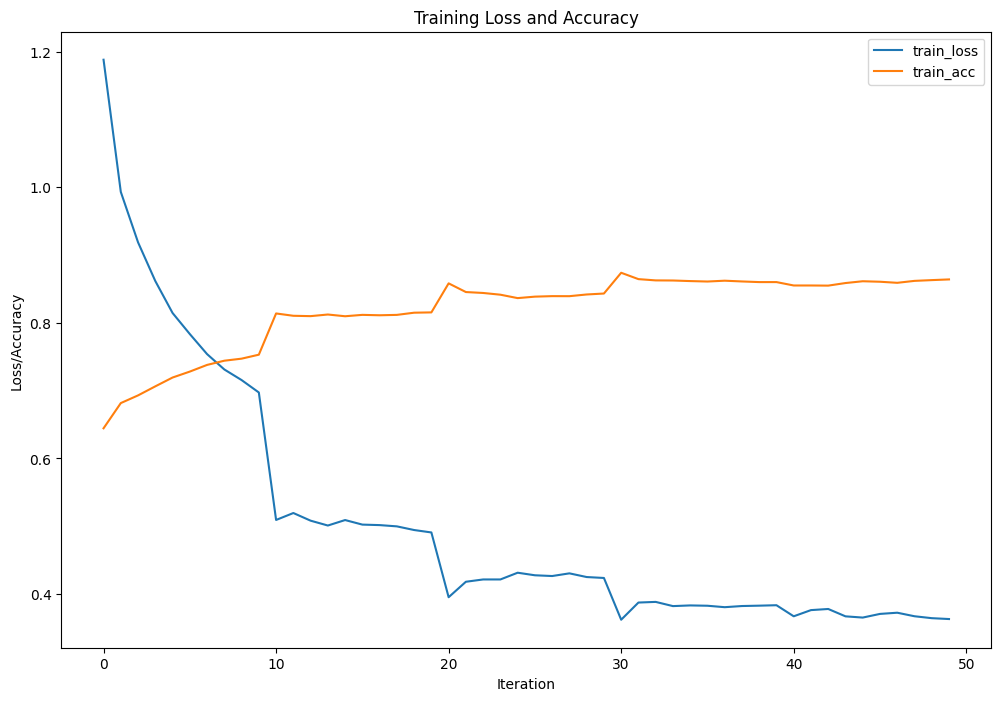

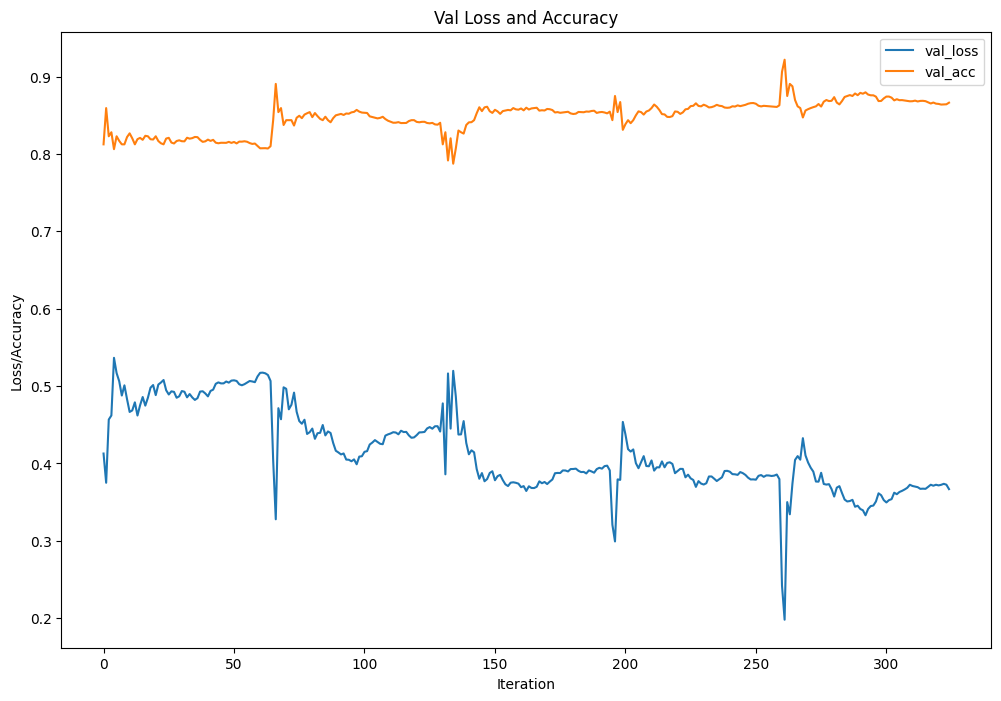

In [28]:
model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_mobilevitv2, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "full_model_mobilevitv2.pth"
# # # Save the trained model
# # torch.save(model_densenet.state_dict(), save_path)
# torch.save(model_mobilevitv2, save_path)

### parsing + oversempling

#### tf_efficientnetv2

[epoch 1], [iter 200/1190], [train loss 0.997], [train acc 0.657]
[epoch 1], [iter 400/1190], [train loss 0.820], [train acc 0.714]
[epoch 1], [iter 600/1190], [train loss 0.732], [train acc 0.741]
[epoch 1], [iter 800/1190], [train loss 0.673], [train acc 0.762]
[epoch 1], [iter 1000/1190], [train loss 0.632], [train acc 0.777]
------------------------------------------------------------
Validation [epoch 1], [loss 0.473], [acc 0.830]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/1190], [train loss 0.418], [train acc 0.851]
[epoch 2], [iter 400/1190], [train loss 0.391], [train acc 0.859]
[epoch 2], [iter 600/1190], [train loss 0.392], [train acc 0.860]
[epoch 2], [iter 800/1190], [train loss 0.382], [train acc 0.862]
[epoch 2], [iter 1000/1190], [train loss 0.378], [train acc 0.864]
------------------------------------------------------------
Validation [epoch 2], [loss 0.540], [acc 0.810]
-----

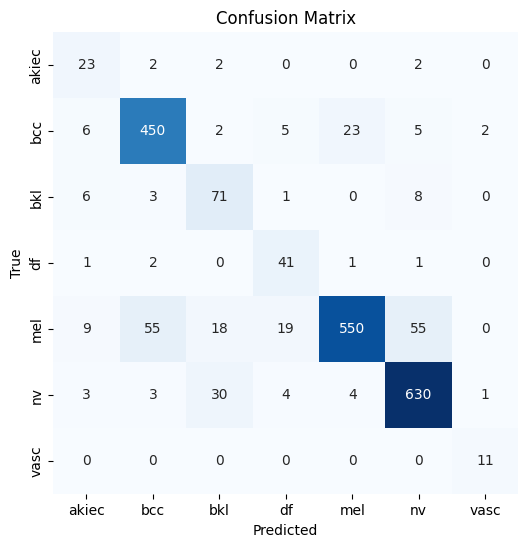

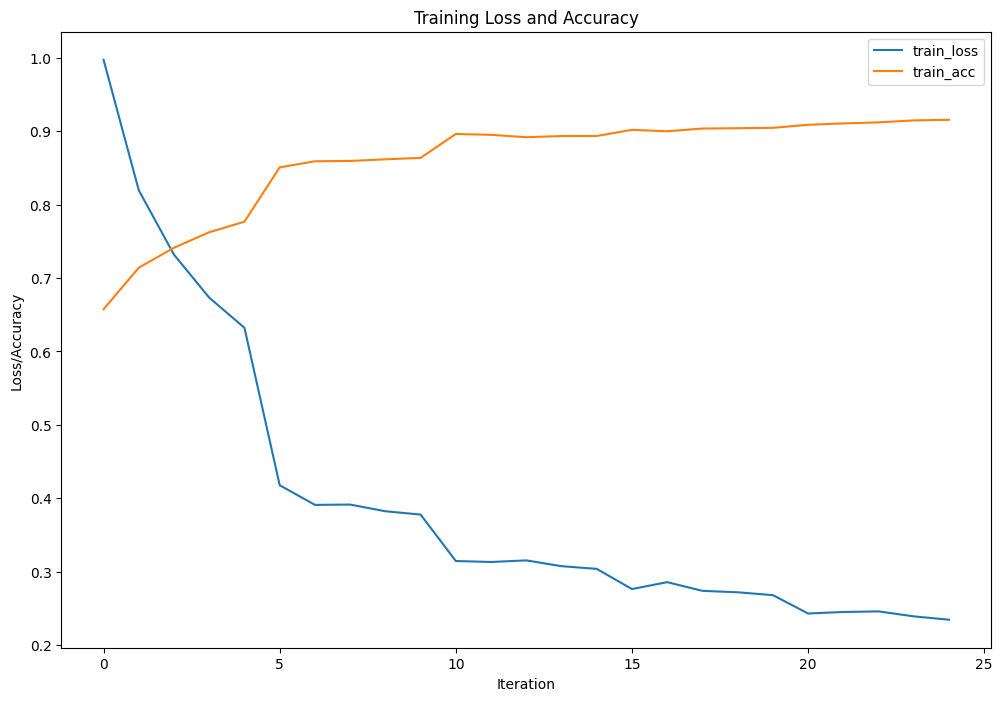

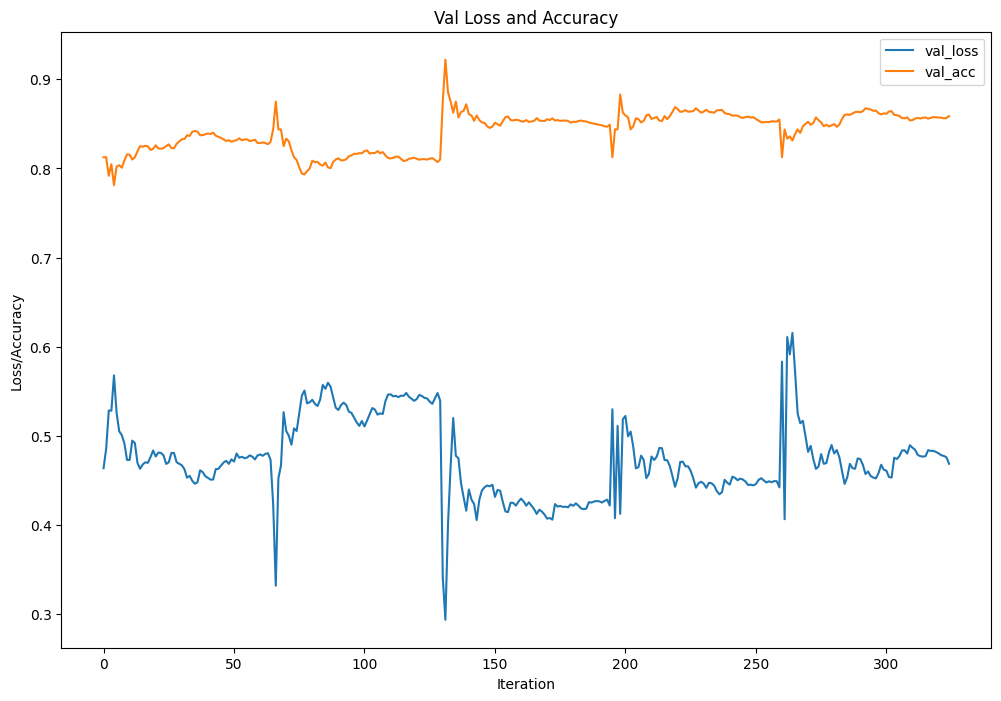

In [14]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)


model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

[epoch 1], [iter 200/864], [train loss 1.017], [train acc 0.646]
[epoch 1], [iter 400/864], [train loss 0.843], [train acc 0.699]
[epoch 1], [iter 600/864], [train loss 0.765], [train acc 0.724]
[epoch 1], [iter 800/864], [train loss 0.708], [train acc 0.744]
------------------------------------------------------------
Validation [epoch 1], [loss 0.541], [acc 0.801]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/864], [train loss 0.506], [train acc 0.821]
[epoch 2], [iter 400/864], [train loss 0.486], [train acc 0.826]
[epoch 2], [iter 600/864], [train loss 0.469], [train acc 0.831]
[epoch 2], [iter 800/864], [train loss 0.462], [train acc 0.831]
------------------------------------------------------------
Validation [epoch 2], [loss 0.497], [acc 0.825]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/864], [trai

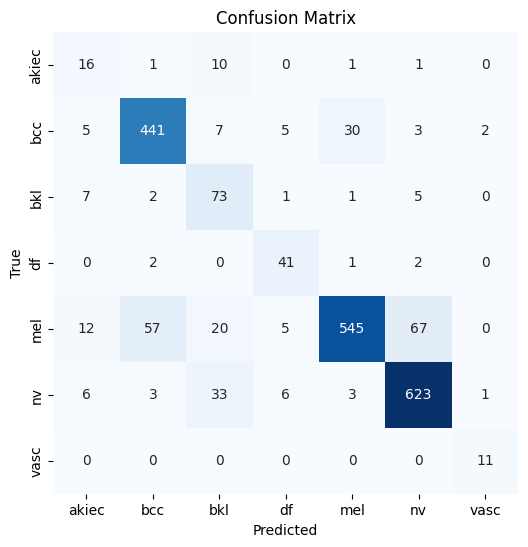

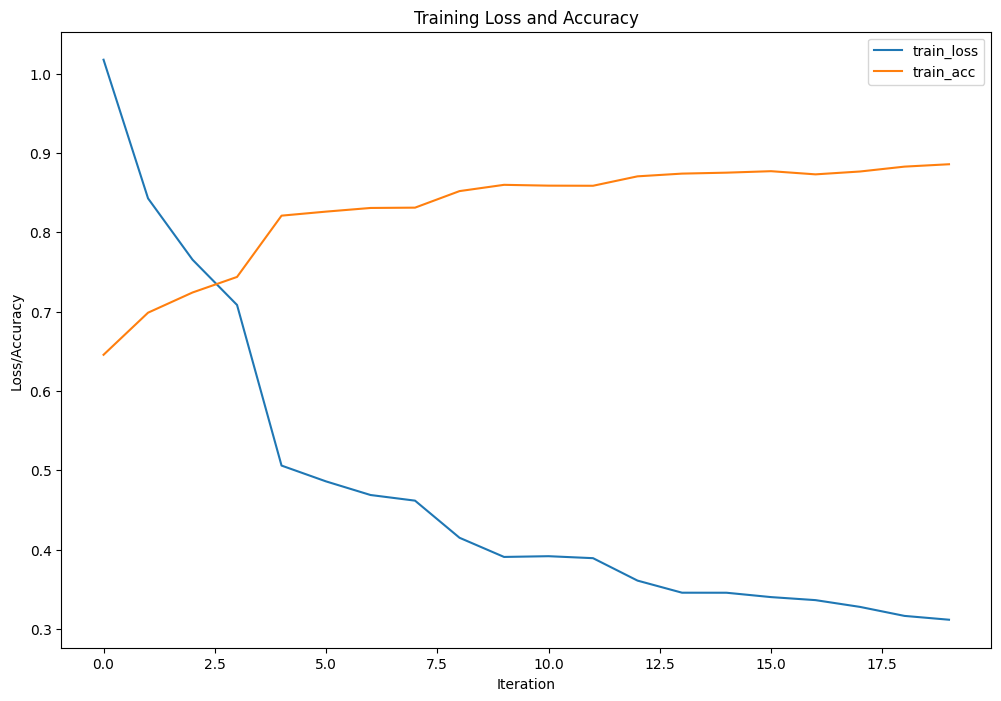

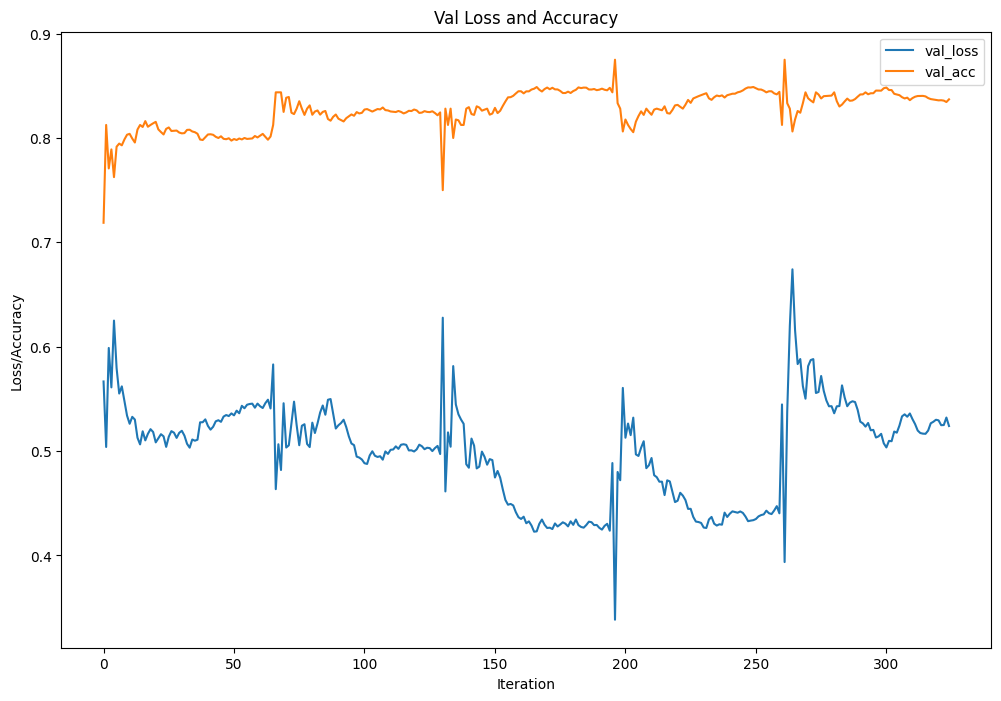

In [24]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 2), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)


model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
# print(f'train time: {round(execution_time/60, 2)} min')
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

[epoch 1], [iter 200/645], [train loss 1.013], [train acc 0.641]
[epoch 1], [iter 400/645], [train loss 0.863], [train acc 0.688]
[epoch 1], [iter 600/645], [train loss 0.791], [train acc 0.712]
------------------------------------------------------------
Validation [epoch 1], [loss 0.519], [acc 0.809]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/645], [train loss 0.572], [train acc 0.786]
[epoch 2], [iter 400/645], [train loss 0.550], [train acc 0.794]
[epoch 2], [iter 600/645], [train loss 0.537], [train acc 0.800]
------------------------------------------------------------
Validation [epoch 2], [loss 0.436], [acc 0.838]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/645], [train loss 0.485], [train acc 0.820]
[epoch 3], [iter 400/645], [train loss 0.476], [train acc 0.820]
[epoch 3], [iter 600/645], [trai

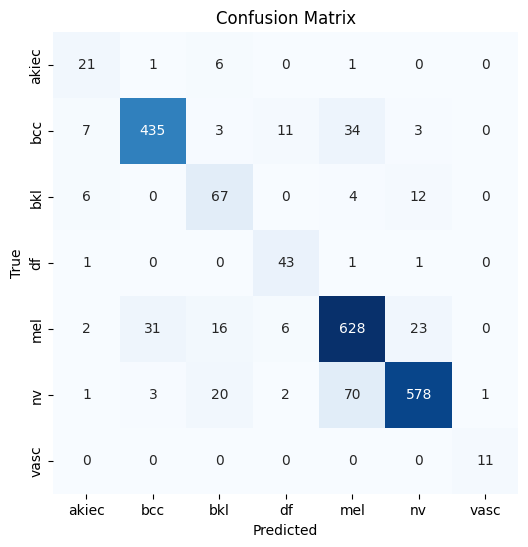

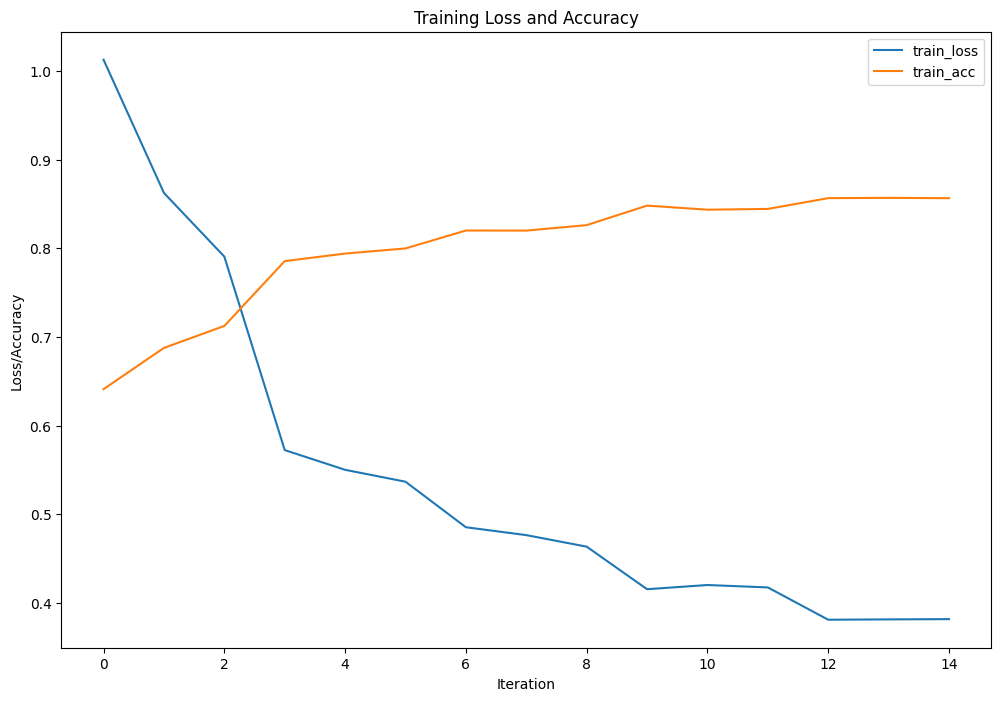

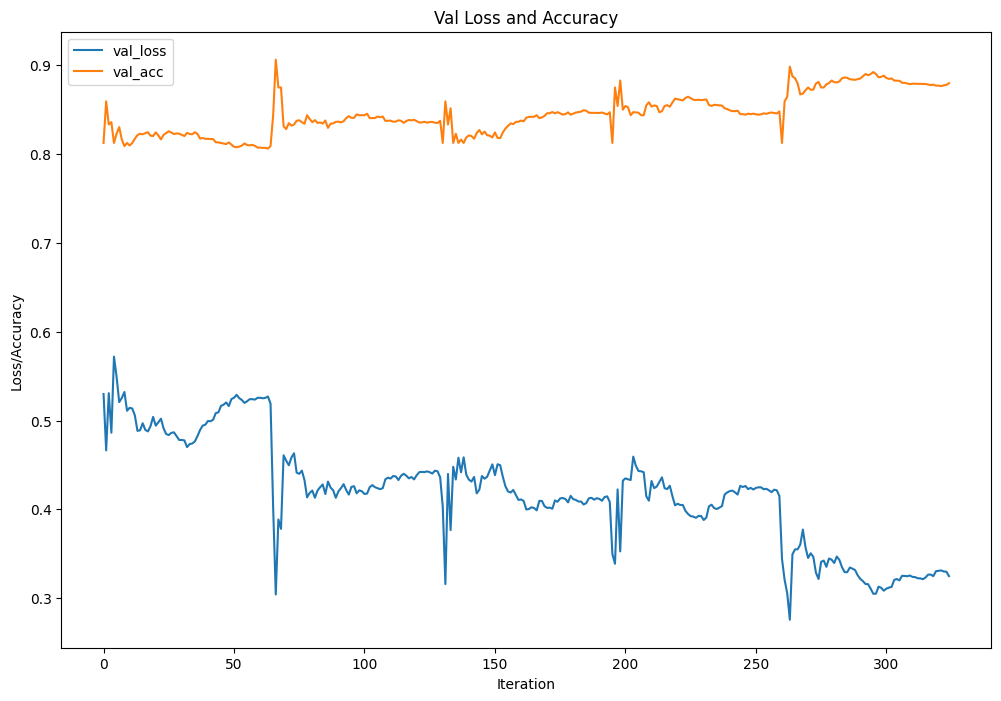

In [9]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 5), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)


model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

[epoch 1], [iter 200/588], [train loss 0.982], [train acc 0.655]
[epoch 1], [iter 400/588], [train loss 0.835], [train acc 0.699]
------------------------------------------------------------
Validation [epoch 1], [loss 0.540], [acc 0.799]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/588], [train loss 0.570], [train acc 0.788]
[epoch 2], [iter 400/588], [train loss 0.548], [train acc 0.795]
------------------------------------------------------------
Validation [epoch 2], [loss 0.433], [acc 0.838]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/588], [train loss 0.493], [train acc 0.818]
[epoch 3], [iter 400/588], [train loss 0.489], [train acc 0.818]
------------------------------------------------------------
Validation [epoch 3], [loss 0.442], [acc 0.846]
-----------------------------------------------------

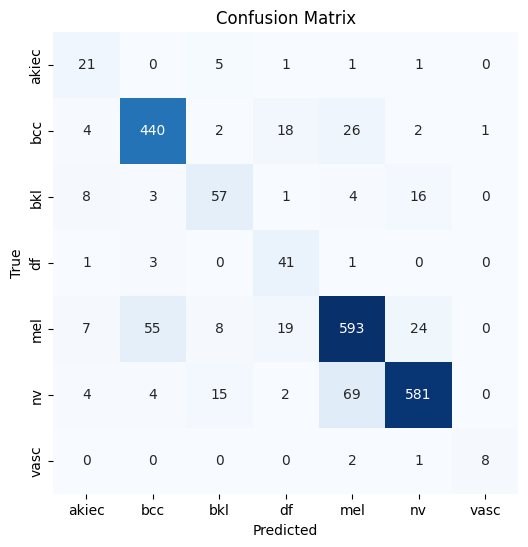

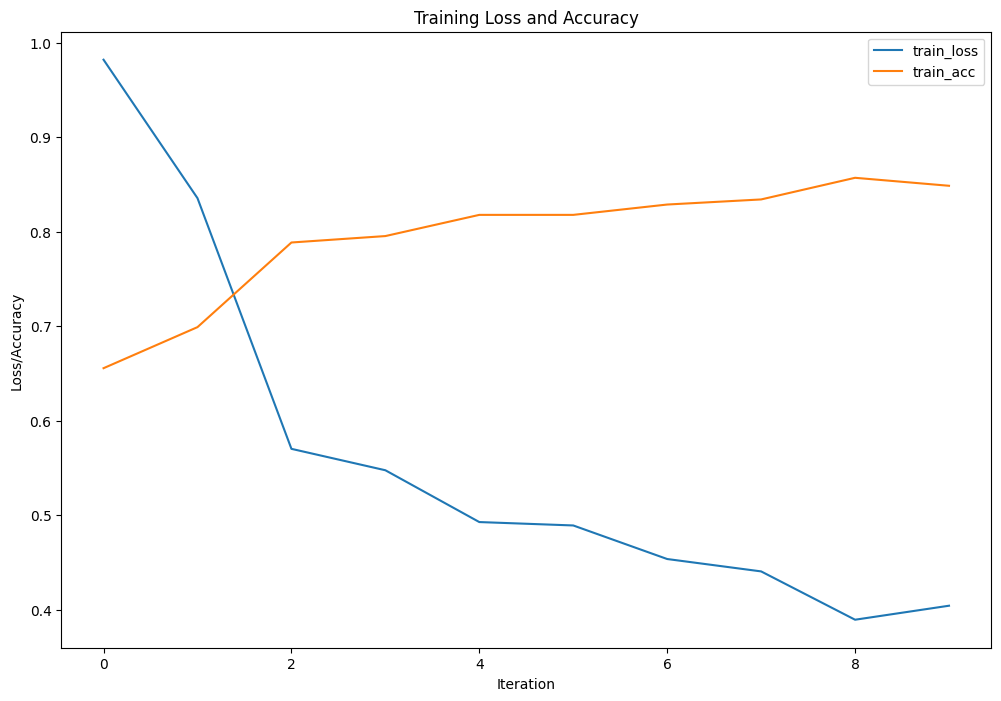

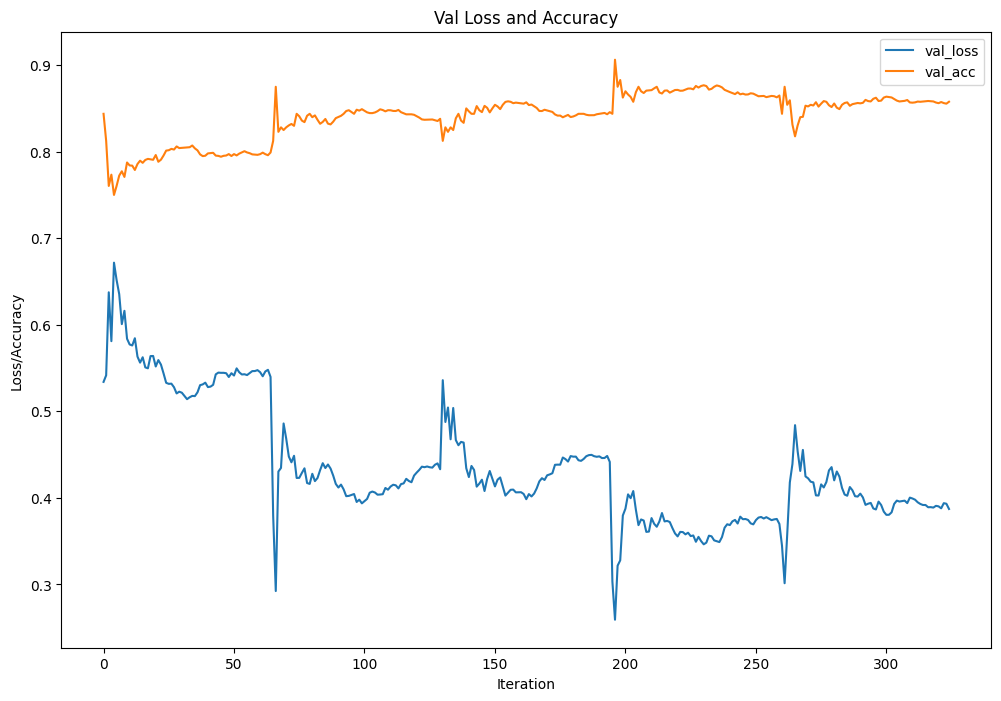

In [26]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 10), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)


model_Efv2 = timm.create_model("tf_efficientnetv2_b1", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_Efv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_Efv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_Efv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_Efv2, criterion, optimizer)

model_Efv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_Efv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### MobileViTv2

[epoch 1], [iter 200/1190], [train loss 0.889], [train acc 0.685]
[epoch 1], [iter 400/1190], [train loss 0.740], [train acc 0.737]
[epoch 1], [iter 600/1190], [train loss 0.662], [train acc 0.766]
[epoch 1], [iter 800/1190], [train loss 0.608], [train acc 0.784]
[epoch 1], [iter 1000/1190], [train loss 0.573], [train acc 0.796]
------------------------------------------------------------
Validation [epoch 1], [loss 0.469], [acc 0.837]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/1190], [train loss 0.356], [train acc 0.868]
[epoch 2], [iter 400/1190], [train loss 0.346], [train acc 0.874]
[epoch 2], [iter 600/1190], [train loss 0.334], [train acc 0.879]
[epoch 2], [iter 800/1190], [train loss 0.328], [train acc 0.882]
[epoch 2], [iter 1000/1190], [train loss 0.321], [train acc 0.885]
------------------------------------------------------------
Validation [epoch 2], [loss 0.411], [acc 0.850]
-----

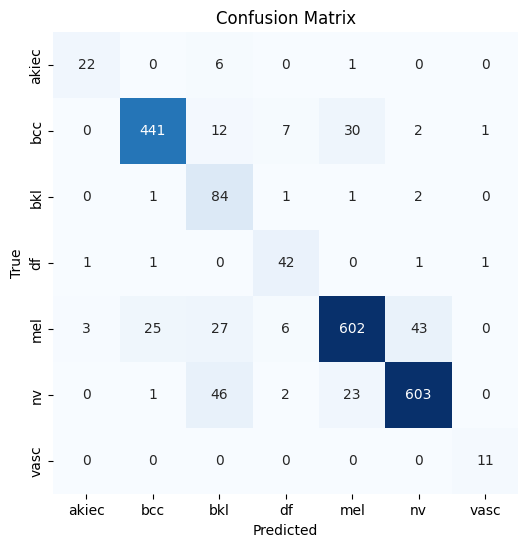

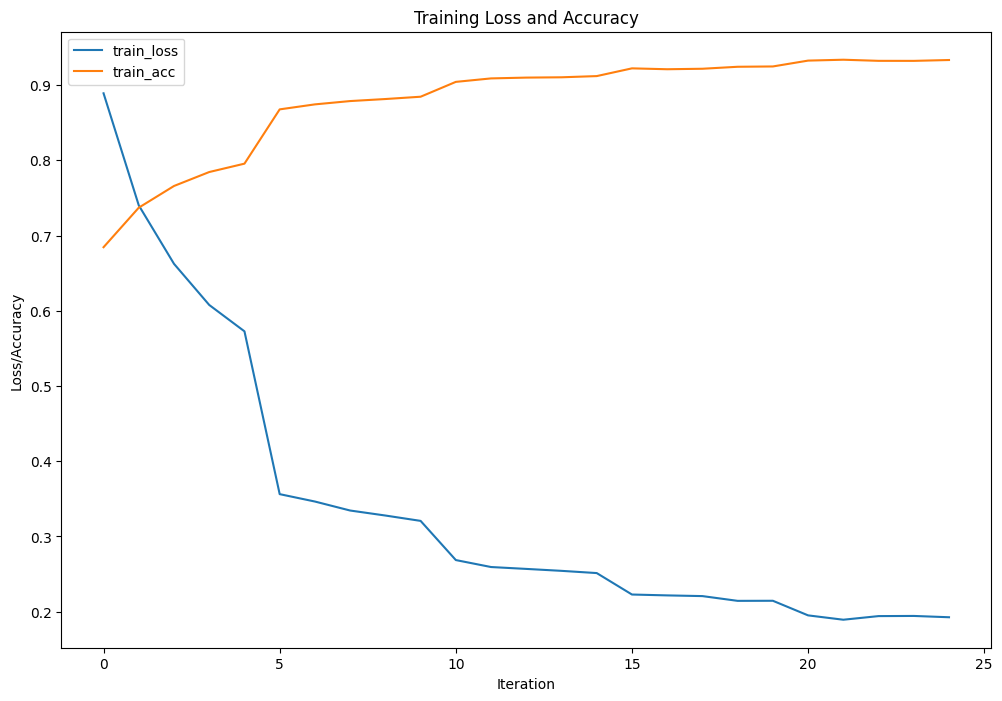

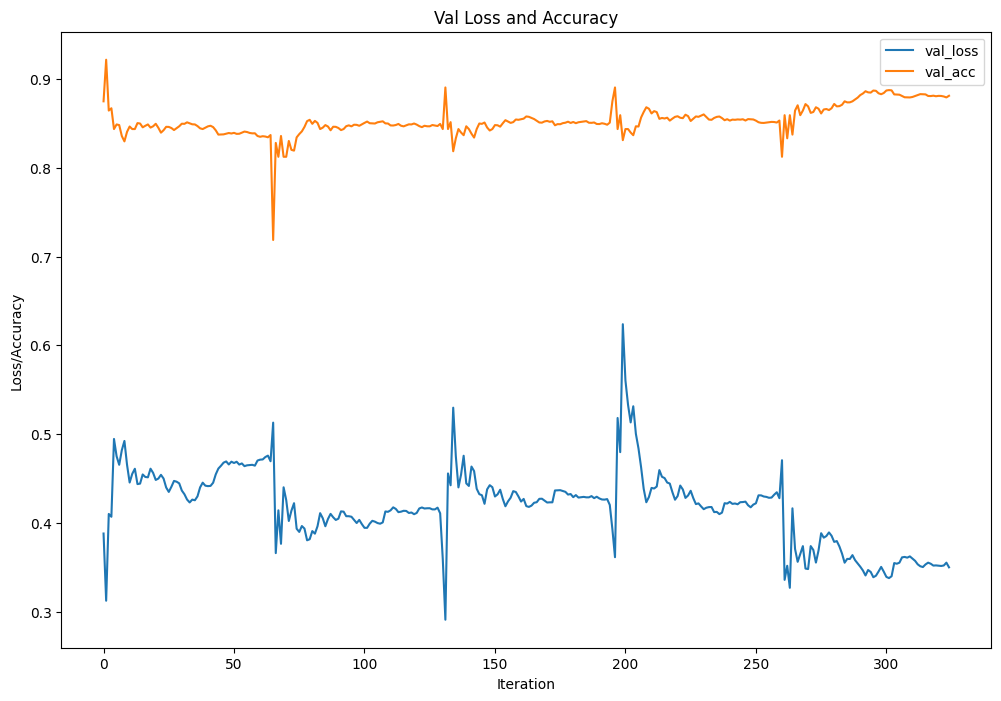

In [13]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx'), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "full_model_mobilevitv2.pth"
# # # Save the trained model
# # torch.save(model_densenet.state_dict(), save_path)
# torch.save(model_mobilevitv2, save_path)

[epoch 1], [iter 200/864], [train loss 0.965], [train acc 0.654]
[epoch 1], [iter 400/864], [train loss 0.803], [train acc 0.709]
[epoch 1], [iter 600/864], [train loss 0.714], [train acc 0.740]
[epoch 1], [iter 800/864], [train loss 0.656], [train acc 0.761]
------------------------------------------------------------
Validation [epoch 1], [loss 0.622], [acc 0.792]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/864], [train loss 0.424], [train acc 0.843]
[epoch 2], [iter 400/864], [train loss 0.430], [train acc 0.842]
[epoch 2], [iter 600/864], [train loss 0.420], [train acc 0.846]
[epoch 2], [iter 800/864], [train loss 0.402], [train acc 0.853]
------------------------------------------------------------
Validation [epoch 2], [loss 0.418], [acc 0.847]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/864], [trai

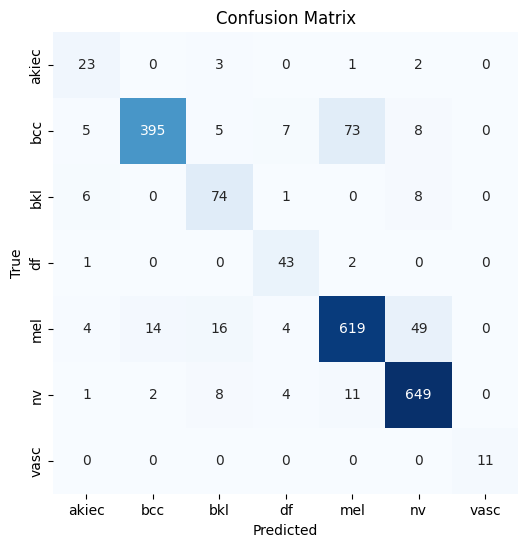

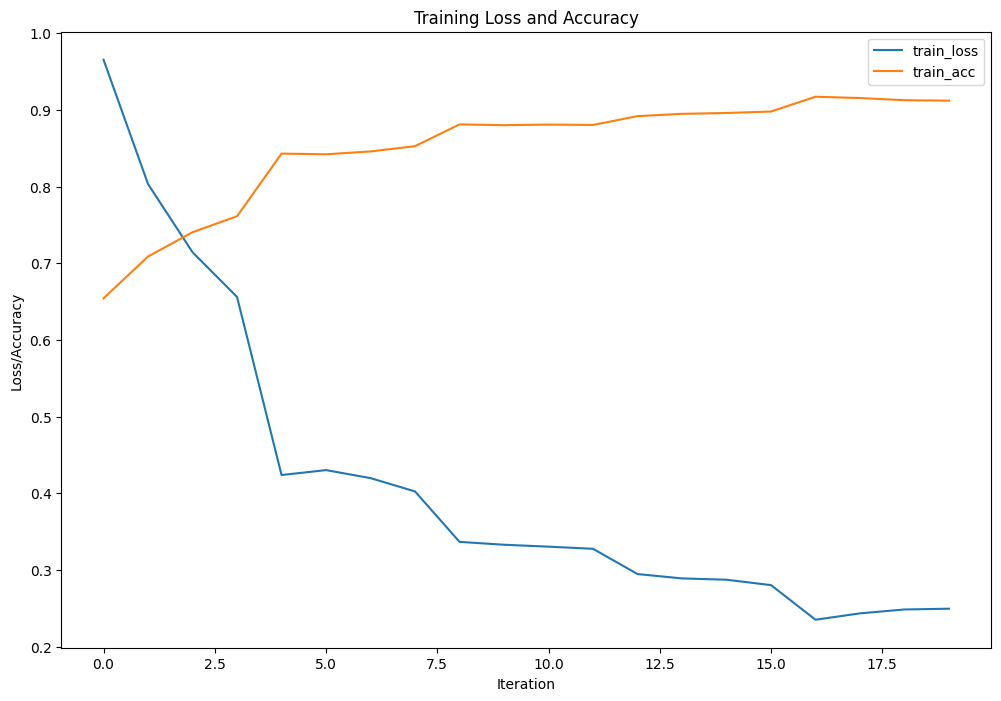

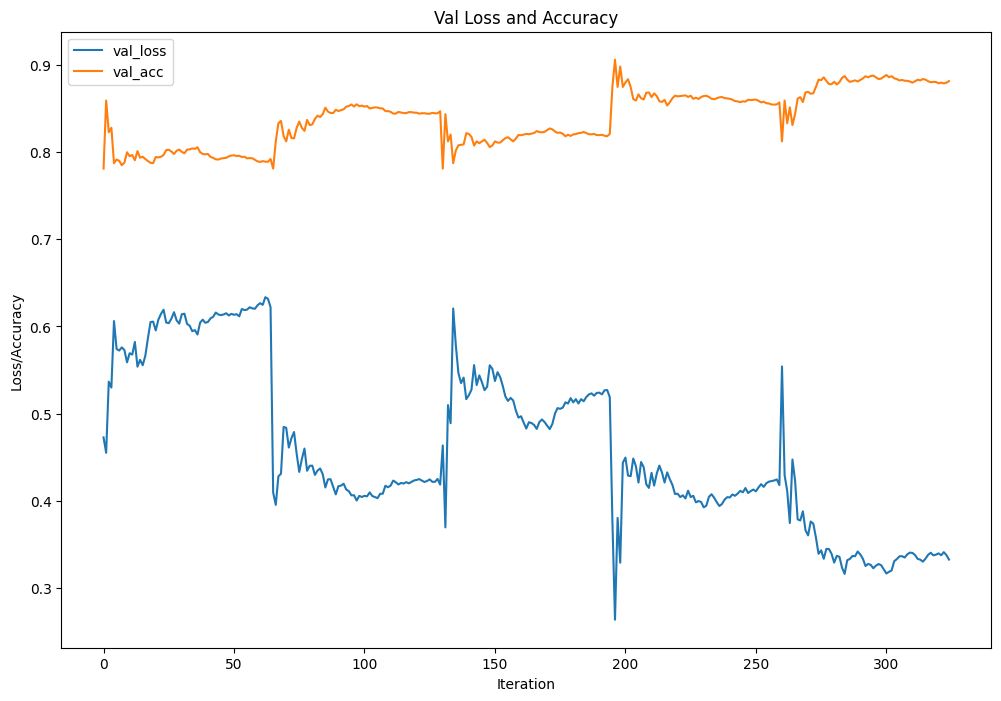

In [27]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 2), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
save_path = "full_model_mobilevitv2.pth"
# # # Save the trained model
# # torch.save(model_densenet.state_dict(), save_path)
torch.save(model_mobilevitv2, save_path)

[epoch 1], [iter 200/645], [train loss 0.950], [train acc 0.665]
[epoch 1], [iter 400/645], [train loss 0.792], [train acc 0.716]
[epoch 1], [iter 600/645], [train loss 0.723], [train acc 0.739]
------------------------------------------------------------
Validation [epoch 1], [loss 0.857], [acc 0.717]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/645], [train loss 0.529], [train acc 0.804]
[epoch 2], [iter 400/645], [train loss 0.502], [train acc 0.814]
[epoch 2], [iter 600/645], [train loss 0.484], [train acc 0.820]
------------------------------------------------------------
Validation [epoch 2], [loss 0.429], [acc 0.849]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/645], [train loss 0.411], [train acc 0.850]
[epoch 3], [iter 400/645], [train loss 0.407], [train acc 0.850]
[epoch 3], [iter 600/645], [trai

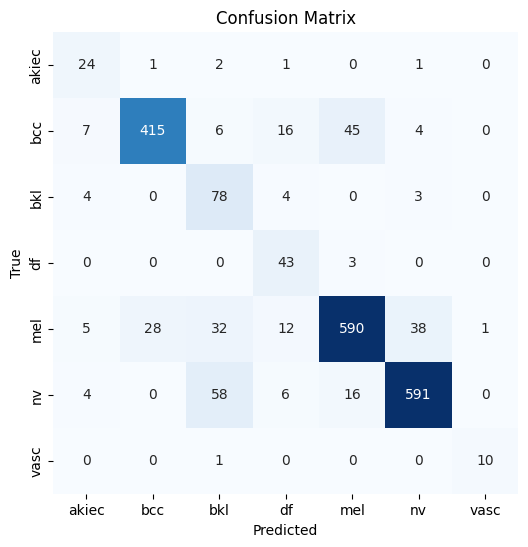

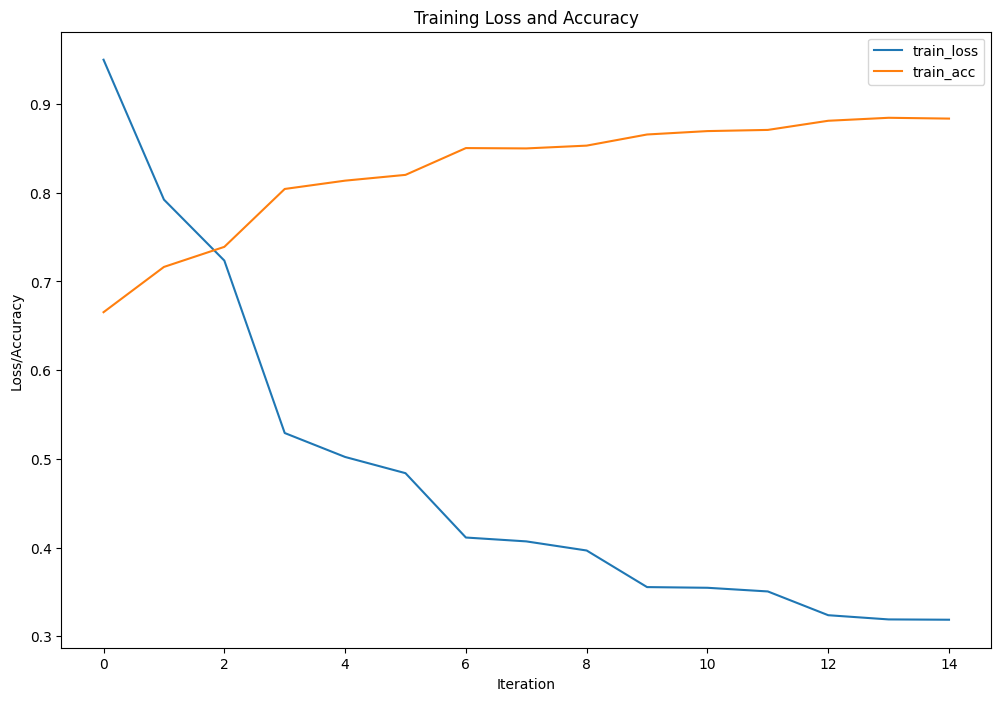

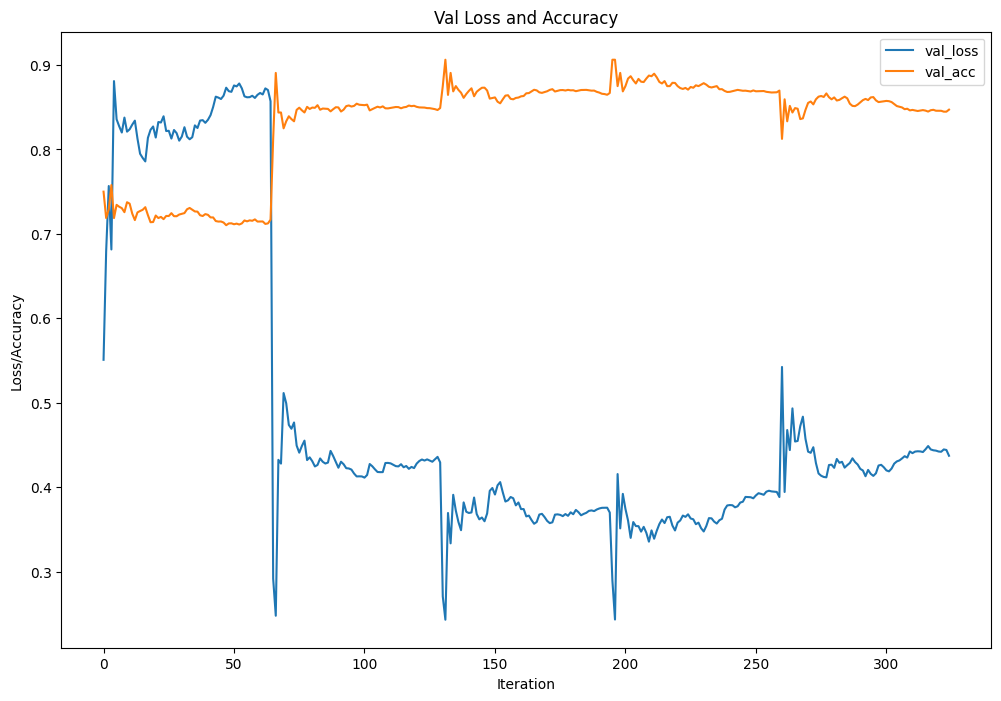

In [28]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 5), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        # pred_labels = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())
        # y_predict.extend(np.squeeze(prediction.max(1)[1].cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "full_model_mobilevitv2.pth"
# # # Save the trained model
# # torch.save(model_densenet.state_dict(), save_path)
# torch.save(model_mobilevitv2, save_path)

[epoch 1], [iter 200/588], [train loss 0.952], [train acc 0.664]
[epoch 1], [iter 400/588], [train loss 0.811], [train acc 0.709]
------------------------------------------------------------
Validation [epoch 1], [loss 0.463], [acc 0.825]
------------------------------------------------------------
*****************************************************
[epoch 2], [iter 200/588], [train loss 0.521], [train acc 0.808]
[epoch 2], [iter 400/588], [train loss 0.516], [train acc 0.809]
------------------------------------------------------------
Validation [epoch 2], [loss 0.367], [acc 0.873]
------------------------------------------------------------
*****************************************************
[epoch 3], [iter 200/588], [train loss 0.429], [train acc 0.844]
[epoch 3], [iter 400/588], [train loss 0.436], [train acc 0.842]
------------------------------------------------------------
Validation [epoch 3], [loss 0.378], [acc 0.865]
-----------------------------------------------------

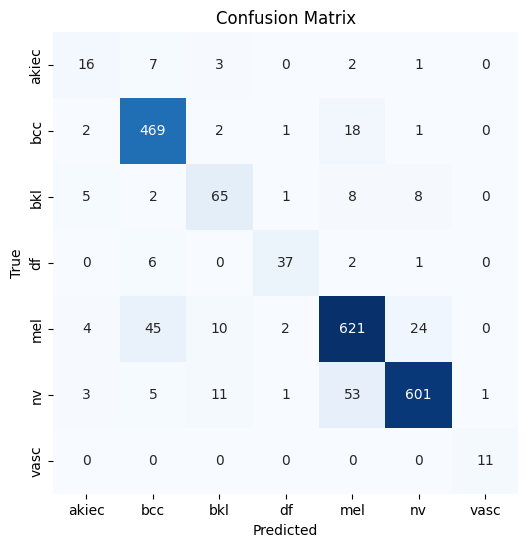

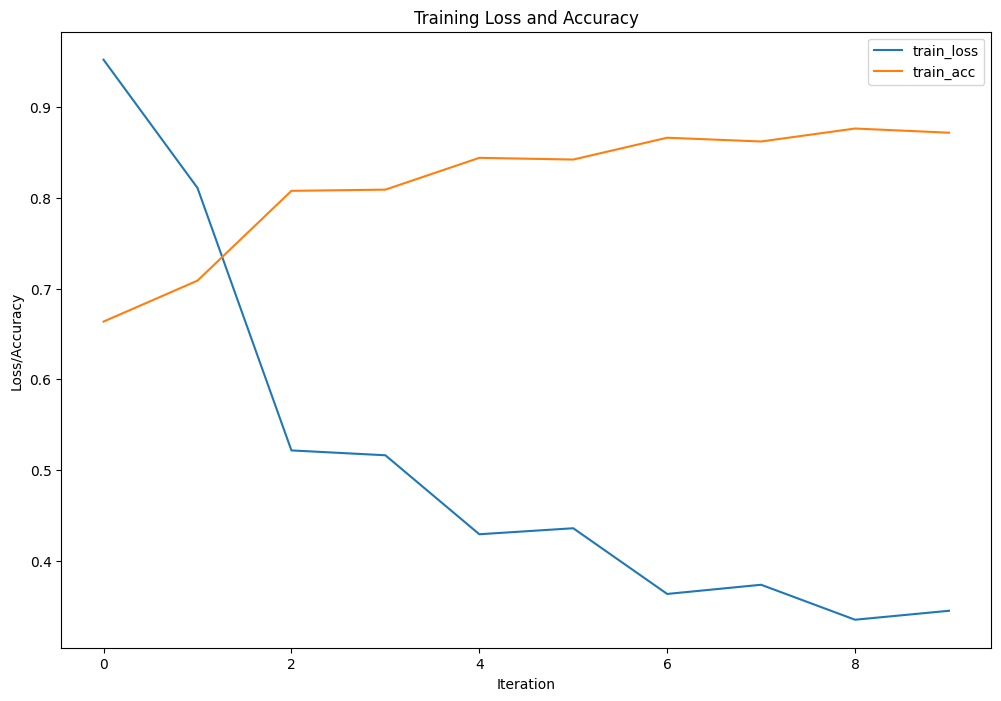

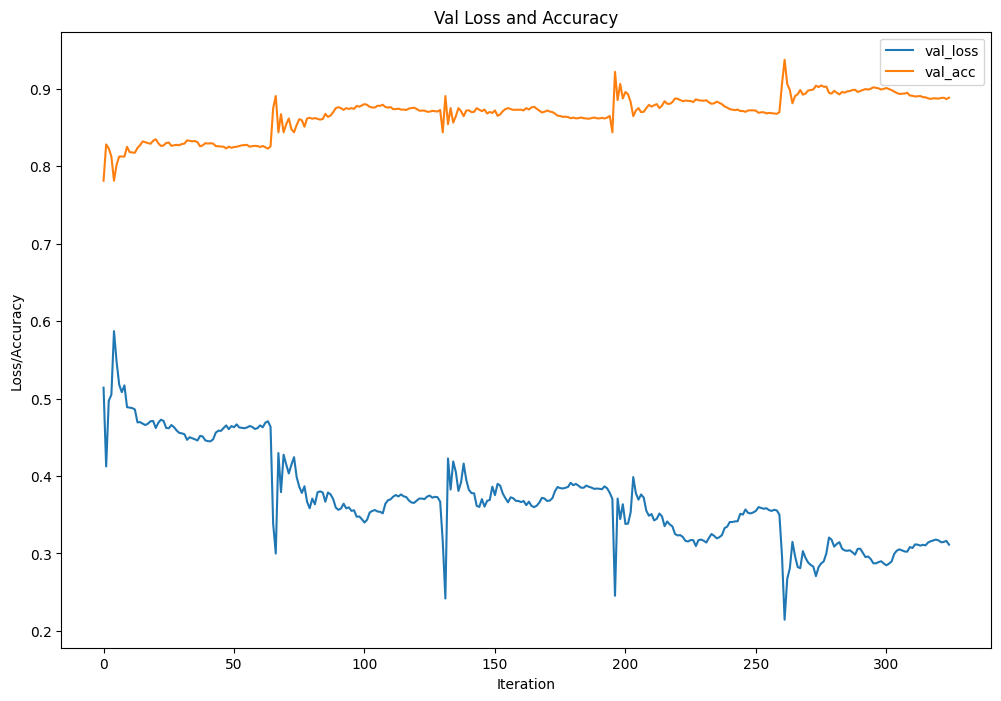

In [29]:
train_exm_dataset_Ef = MNISTHAM10000(root, train_df, True, multiply_factor(train_df, 'dx', 10), img_transform, mask_transform)
train_loader_Ef = DataLoader(
    train_exm_dataset_Ef, batch_size=32, shuffle=True)

exm_dataset_Ef = MNISTHAM10000(root, val_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
val_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

exm_dataset_Ef = MNISTHAM10000(root, test_df, False, multiply_factor(train_df, 'dx'), test_transform, mask_transform)
test_loader_Ef = DataLoader(
    exm_dataset_Ef, batch_size=32, shuffle=False)

model_mobilevitv2 = timm.create_model("mobilevitv2_100", pretrained=True, num_classes=7)

optimizer = optim.AdamW(model_mobilevitv2.parameters(), lr=0.001) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader_Ef, model_mobilevitv2, criterion, optimizer, epoch, 200)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader_Ef, model_mobilevitv2, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    # writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
# file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'Train time: {int(execution_time // 60)}m {int(execution_time % 60)}s')

total_loss_test, total_acc_test = model_test(test_loader_Ef, model_mobilevitv2, criterion, optimizer)

model_mobilevitv2.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader_Ef):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_mobilevitv2(images)
        prediction = outputs.argmax(dim=1).cpu().numpy()
        y_label.extend(labels.cpu().numpy())
        if prediction.ndim == 0:  # Если скаляр (0-D)
            y_predict.append(prediction.item())
        else:  # Если массив (1-D и более)
            y_predict.extend(prediction.tolist())

report = classification_report(y_label, y_predict)
print(report)

cm_modvitv2 = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_modvitv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
# save_path = "full_model_mobilevitv2.pth"
# # # Save the trained model
# # torch.save(model_densenet.state_dict(), save_path)
# torch.save(model_mobilevitv2, save_path)